In [1]:
import pandas as pd
import numpy as np
import ast

import os
import matplotlib.pyplot as plt
import seaborn as sns
from plinder_analysis_utils import DockingAnalysisBase, PoseBustersAnalysis, PropertyAnalysis

import statsmodels.formula.api as smf

# Load Data 

In [2]:
BUST_TEST_COLUMNS = [
    # accuracy #
    "rmsd_≤_2å",
    # chemical validity and consistency #
    "mol_pred_loaded",
    "mol_true_loaded",
    "mol_cond_loaded",
    "sanitization",
    "molecular_formula",
    "molecular_bonds",
    "tetrahedral_chirality",
    "double_bond_stereochemistry",
    # intramolecular validity #
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    # intermolecular validity #
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
]

In [3]:
df_combined = pd.read_csv("plinder_set_0_annotated.csv")
# build a boolean mask: drop any row where covalent, ionic or has_ion is True
mask = ~(
    df_combined['ligand_is_covalent'] |
    df_combined['ligand_is_ion'] |
    df_combined['has_ion'] |
    df_combined['ligand_is_cofactor']
)

# filter and reset index
df_combined = df_combined.loc[mask].reset_index(drop=True)
print("Filtered shape:", df_combined.shape)

Filtered shape: (14961, 154)


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/2327914646.py:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("plinder_set_0_annotated.csv")


# Analysis

In [5]:
# Initialize the analysis object
analysis = PoseBustersAnalysis(df_combined)

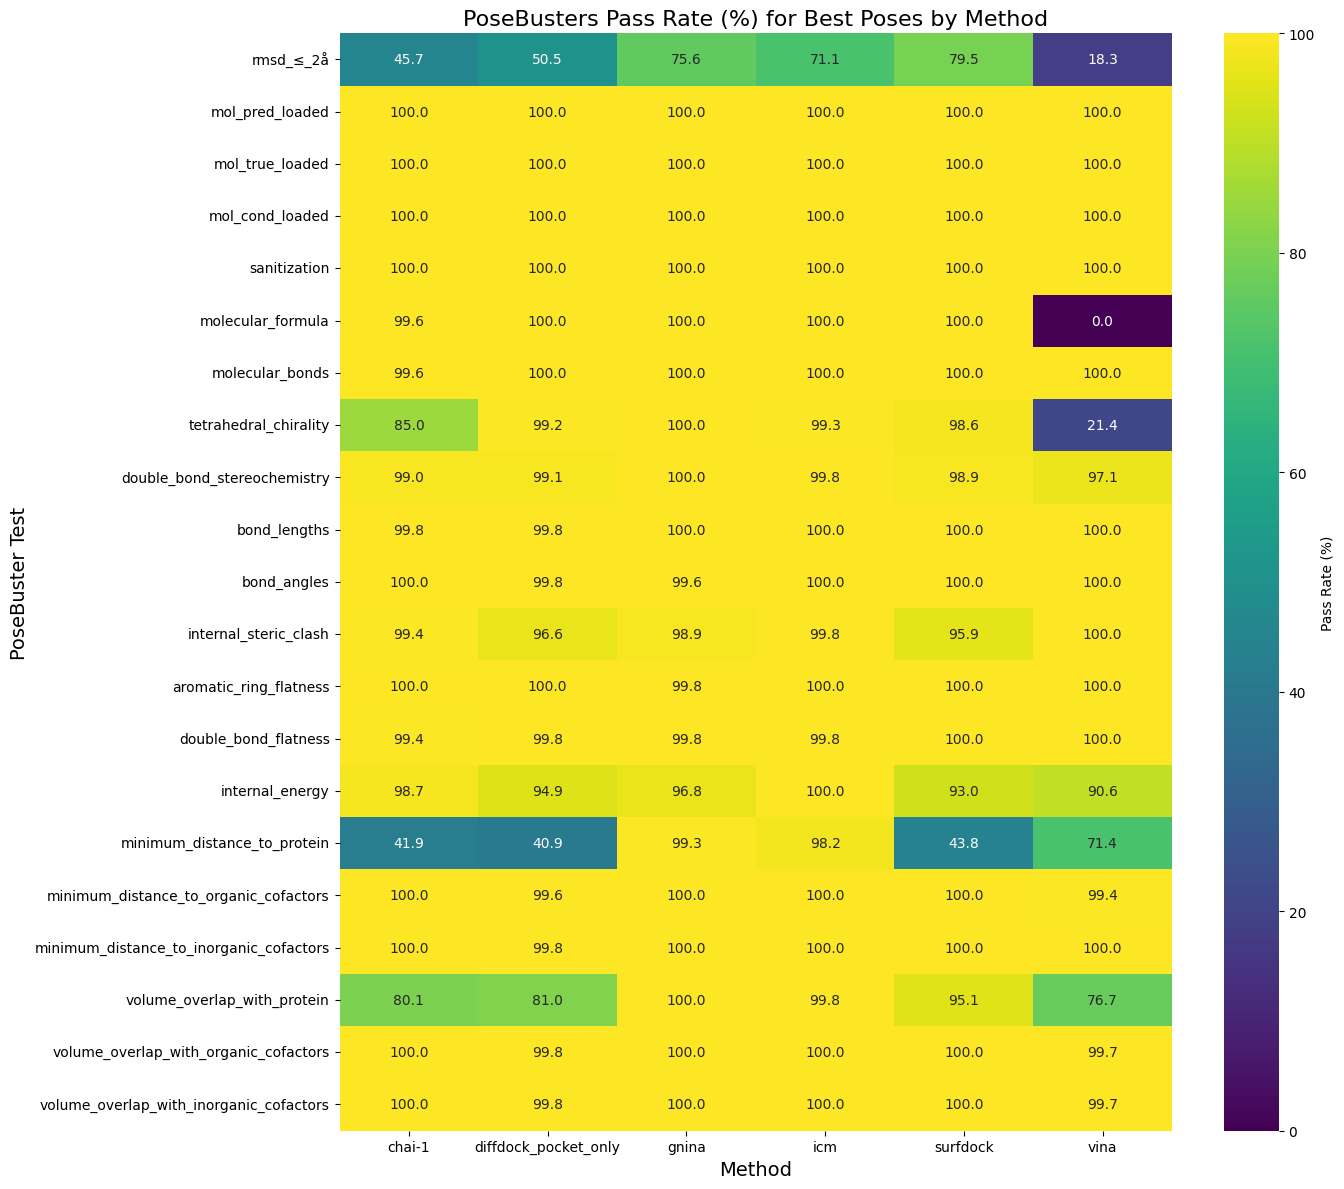

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=overall_pass_rates[sorted_methods], palette='viridis')


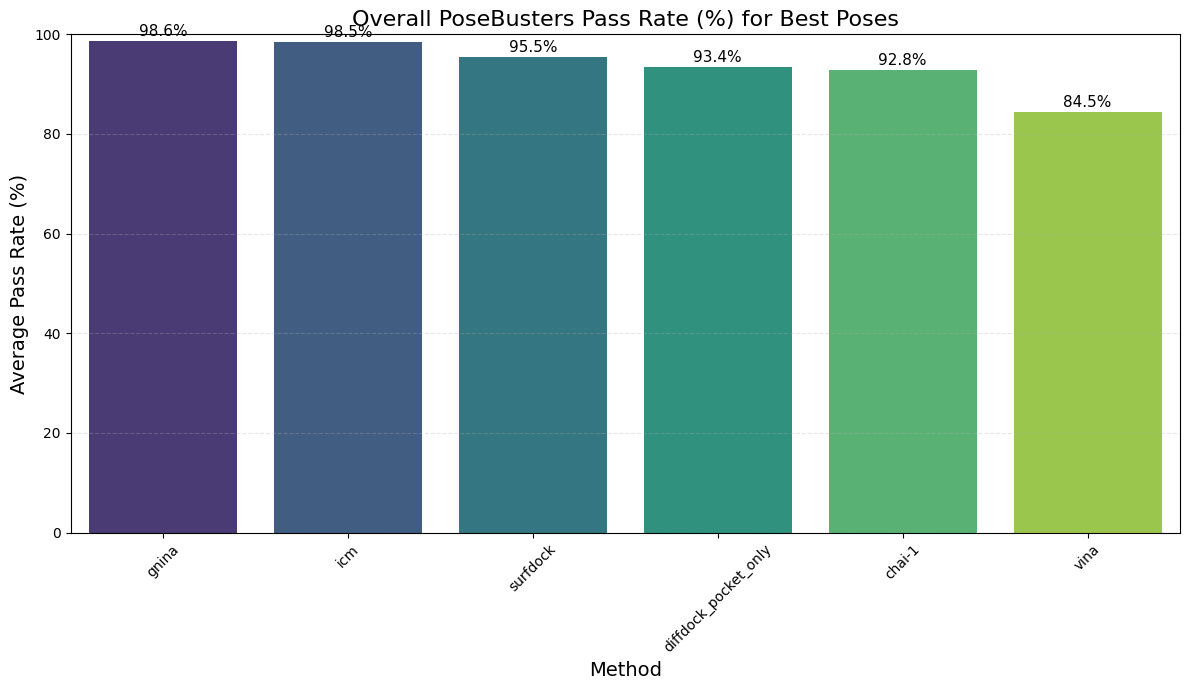

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')


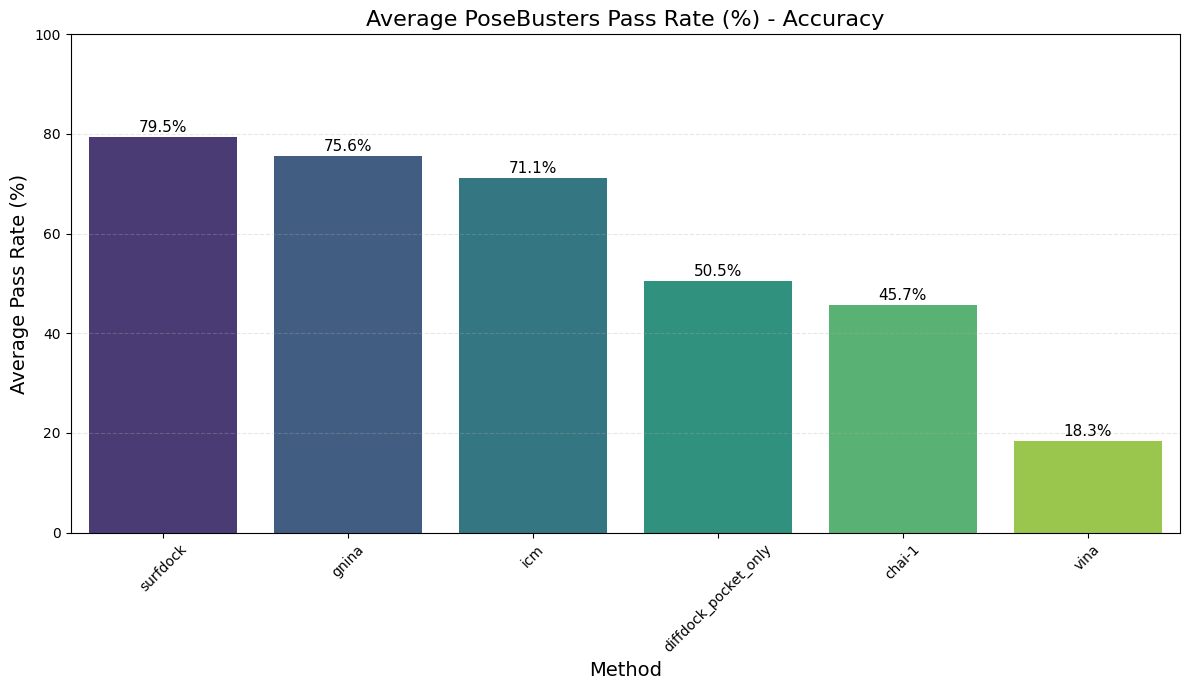

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')


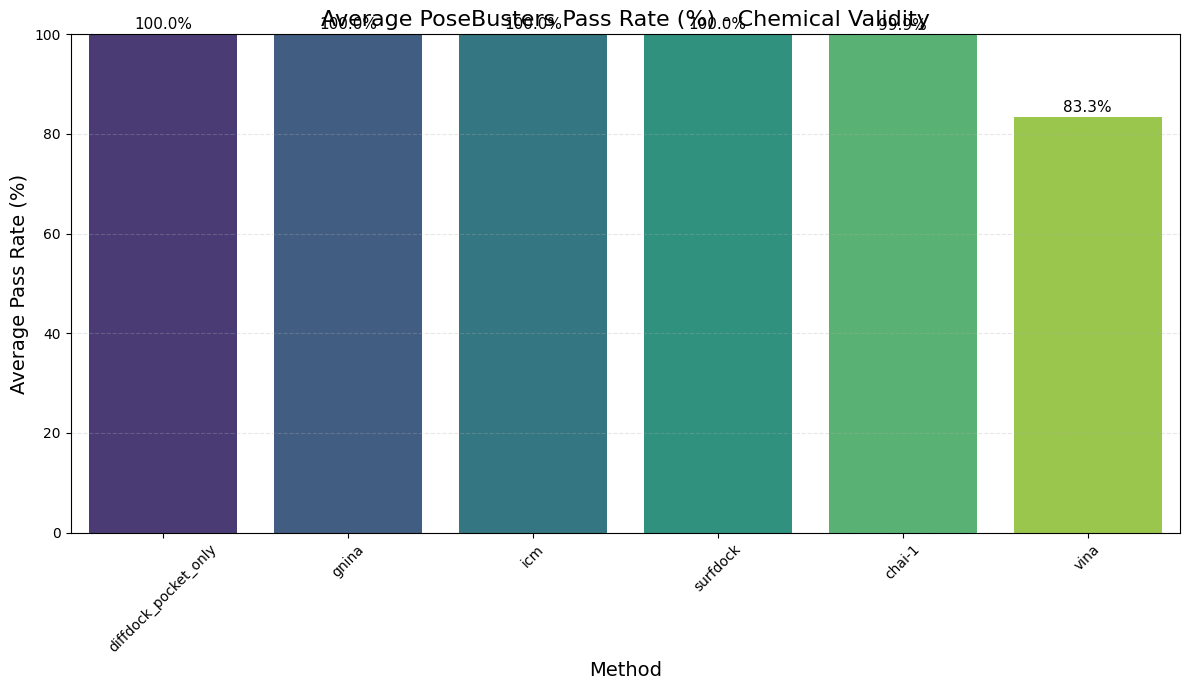

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')


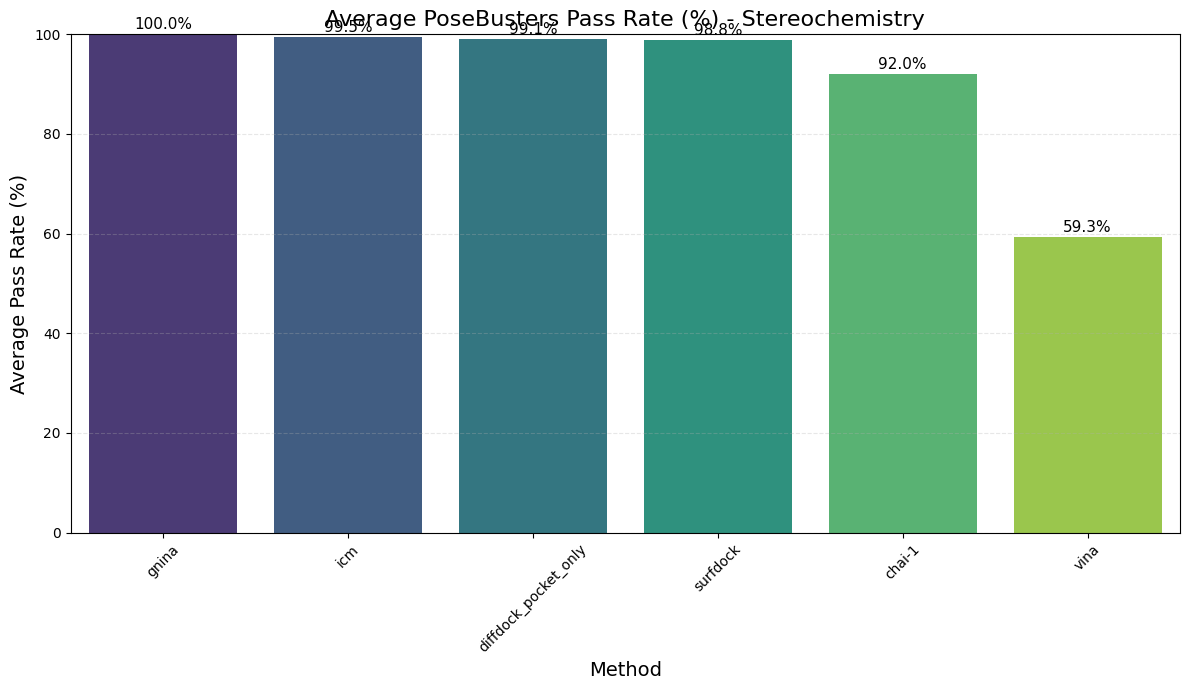

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')


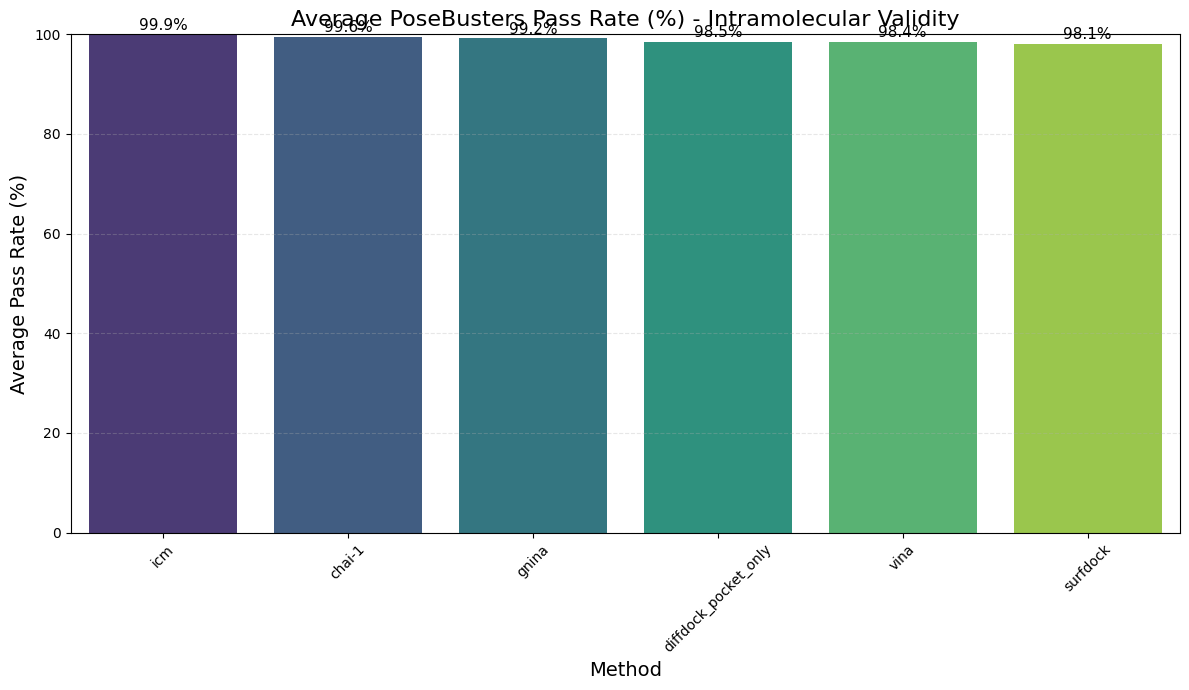

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_51722/525917670.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')


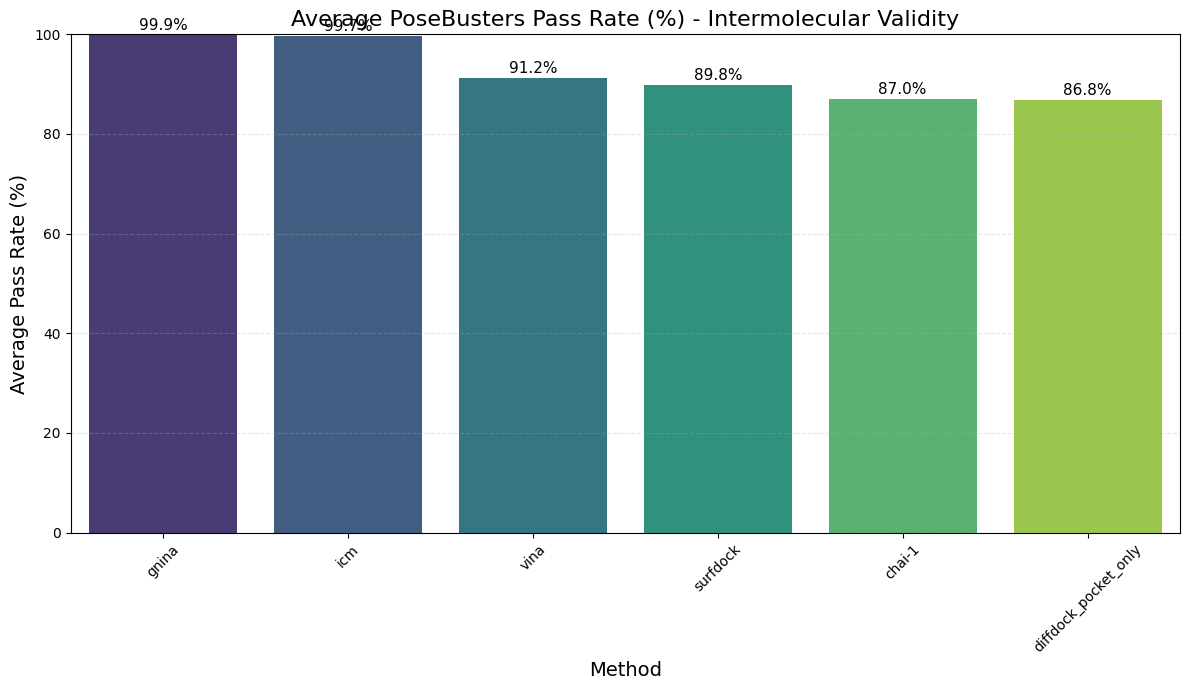

In [9]:
# Find the best pose (lowest RMSD) for each method and protein
best_poses = df_combined.loc[df_combined.groupby(['protein', 'method'])['rmsd'].idxmin()]

# List of methods to analyze
methods = best_poses['method'].unique()

# Calculate pass rate for each method and each PoseBuster test
pass_rates_df = pd.DataFrame(index=BUST_TEST_COLUMNS, columns=methods)
pass_rates_df = pass_rates_df.astype(float)  # Explicitly convert to float type

for method in methods:
    method_poses = best_poses[best_poses['method'] == method]
    for test in BUST_TEST_COLUMNS:
        if test in method_poses.columns:
            # First convert the test column to numeric values if they're boolean
            if pd.api.types.is_bool_dtype(method_poses[test]):
                numeric_values = method_poses[test].astype(float)
            else:
                # Try to convert to numeric, coerce errors to NaN
                numeric_values = pd.to_numeric(method_poses[test], errors='coerce')
                
            # Calculate mean of valid entries
            valid_values = numeric_values.dropna()
            if len(valid_values) > 0:
                pass_rates_df.loc[test, method] = valid_values.mean() * 100
            else:
                pass_rates_df.loc[test, method] = np.nan

# Create a heatmap with better formatting
plt.figure(figsize=(14, 12))
ax = sns.heatmap(pass_rates_df, annot=True, cmap='viridis', fmt='.1f', 
            cbar_kws={'label': 'Pass Rate (%)'})
plt.title('PoseBusters Pass Rate (%) for Best Poses by Method', fontsize=16)
plt.ylabel('PoseBuster Test', fontsize=14)
plt.xlabel('Method', fontsize=14)
plt.tight_layout()
plt.show()

# Group PoseBuster tests into categories for more organized analysis
categories = {
    'Accuracy': ['rmsd_≤_2å'],
    'Chemical Validity': ['mol_pred_loaded', 'mol_true_loaded', 'mol_cond_loaded', 
                        'sanitization', 'molecular_formula', 'molecular_bonds'],
    'Stereochemistry': ['tetrahedral_chirality', 'double_bond_stereochemistry'],
    'Intramolecular Validity': ['bond_lengths', 'bond_angles', 'internal_steric_clash', 
                              'aromatic_ring_flatness', 'double_bond_flatness', 'internal_energy'],
    'Intermolecular Validity': ['minimum_distance_to_protein', 'minimum_distance_to_organic_cofactors', 
                              'minimum_distance_to_inorganic_cofactors', 'volume_overlap_with_protein',
                              'volume_overlap_with_organic_cofactors', 'volume_overlap_with_inorganic_cofactors']
}

# Calculate overall pass rate for each method
overall_pass_rates = pass_rates_df.mean()

# Create a bar chart for overall pass rates with better formatting
plt.figure(figsize=(12, 7))
# Sort methods by overall performance
sorted_methods = overall_pass_rates.sort_values(ascending=False).index
ax = sns.barplot(x=sorted_methods, y=overall_pass_rates[sorted_methods], palette='viridis')
plt.title('Overall PoseBusters Pass Rate (%) for Best Poses', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Pass Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Add value labels on top of bars
for i, v in enumerate(overall_pass_rates[sorted_methods]):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot category-specific pass rates
for category, tests in categories.items():
    category_pass_rates = pass_rates_df.loc[tests].mean()
    plt.figure(figsize=(12, 7))
    sorted_methods = category_pass_rates.sort_values(ascending=False).index
    ax = sns.barplot(x=sorted_methods, y=category_pass_rates[sorted_methods], palette='viridis')
    plt.title(f'Average PoseBusters Pass Rate (%) - {category}', fontsize=16)
    plt.xlabel('Method', fontsize=14)
    plt.ylabel('Average Pass Rate (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    
    # Add value labels
    for i, v in enumerate(category_pass_rates[sorted_methods]):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11)
        
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Universal

Analyzing PoseBusters metrics for 15 cases where all methods succeed
and 17 cases where all methods fail


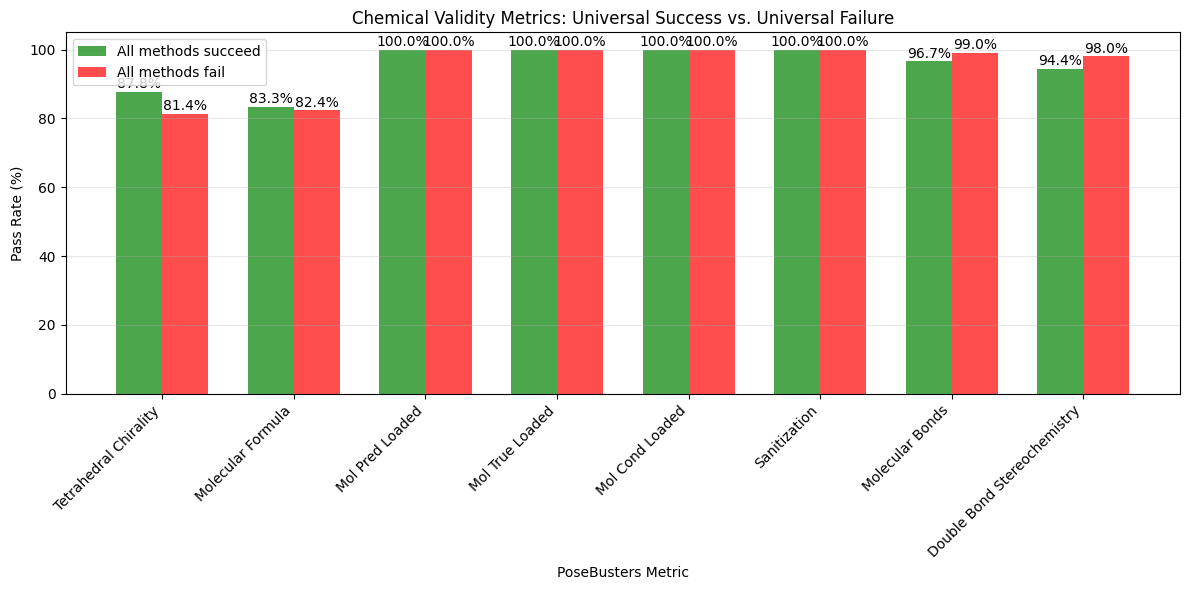

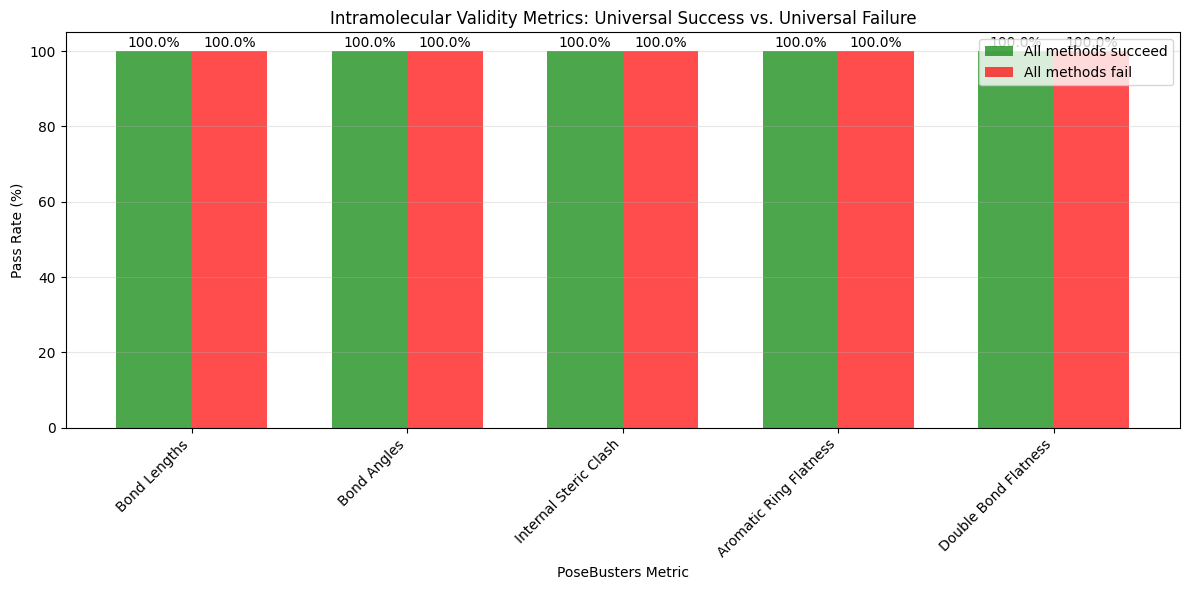

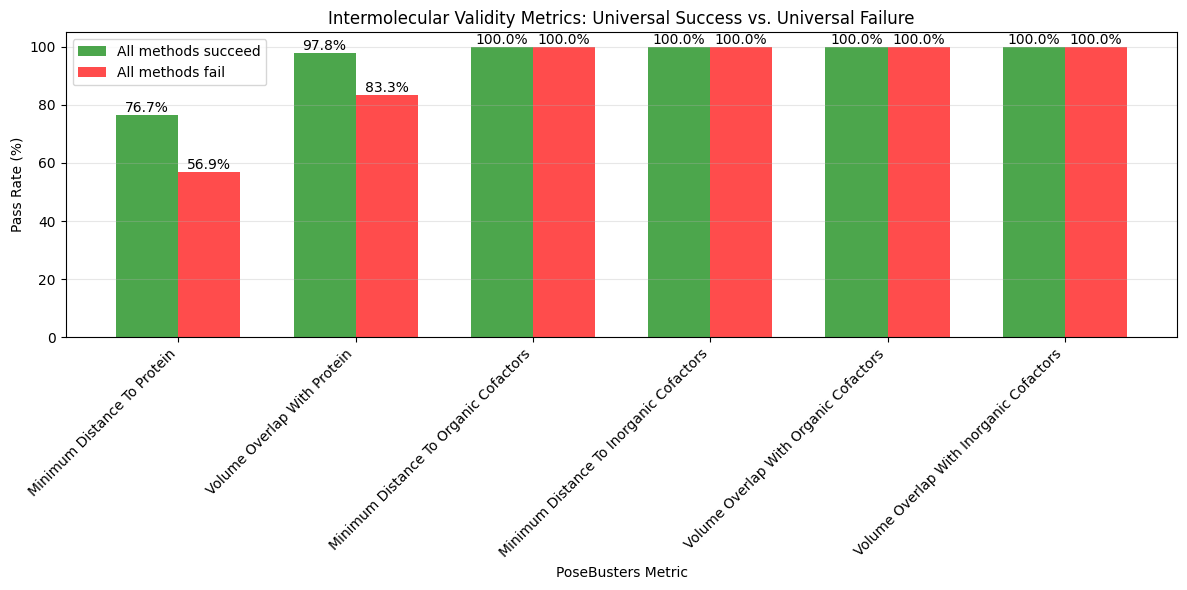

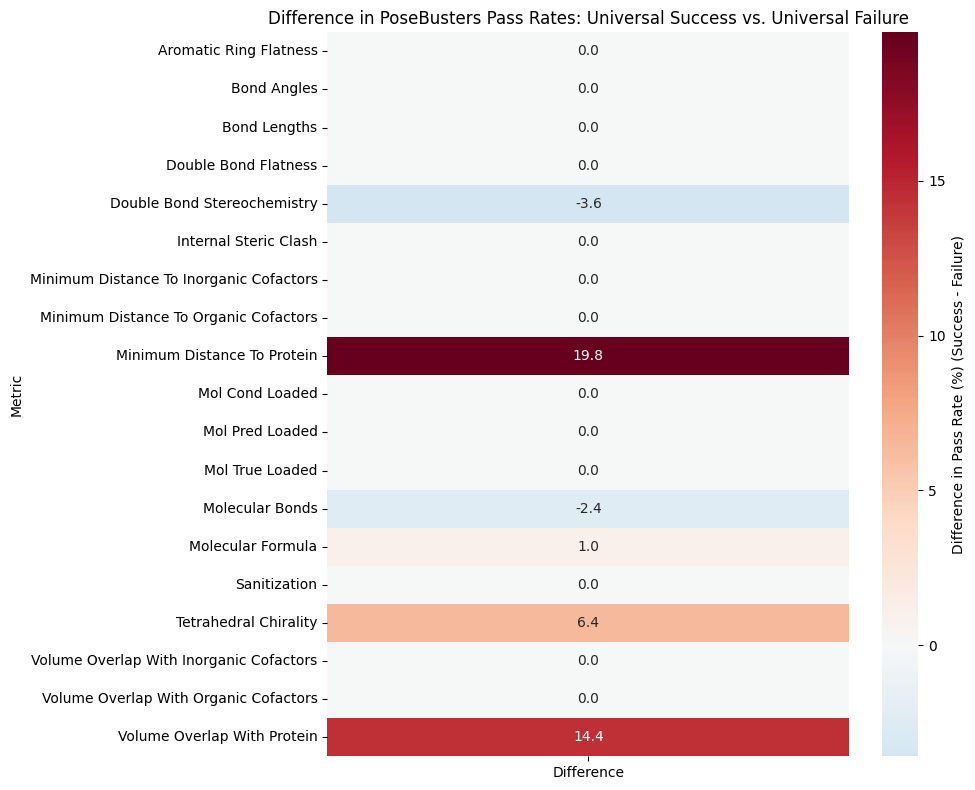


No statistically significant differences found in PoseBusters metrics.


In [5]:
# List of methods to include in analysis
methods = ['diffdock_pocket_only', 'chai-1', 'icm', 'gnina', 'surfdock', 'vina']

# Run the universal analysis
universal_results = analysis.analyze_universal(
    methods=methods,
    rmsd_threshold=2.0,
    plot=True
)

# Access key results
success_proteins = universal_results['all_success_proteins']
failure_proteins = universal_results['all_failure_proteins']
significant_metrics = universal_results['significant_metrics']

### physics-based

In [8]:
df_combined.shape, df_combined['protein'].nunique()

((14961, 154), 562)

Analyzing PoseBusters metrics for 57 cases where all methods succeed
and 118 cases where all methods fail


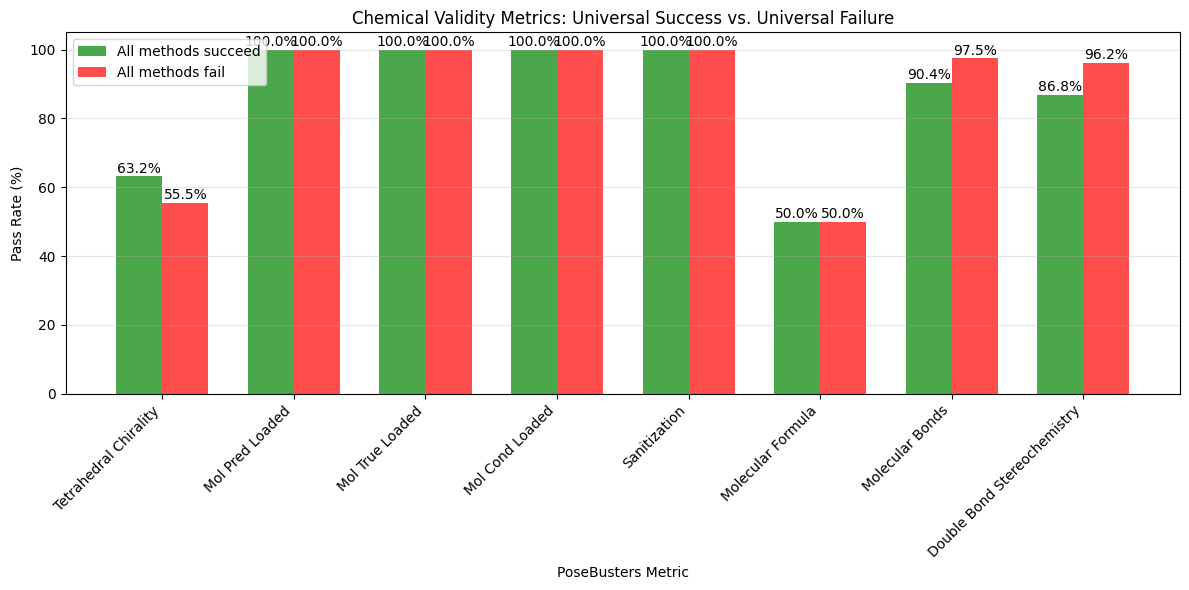

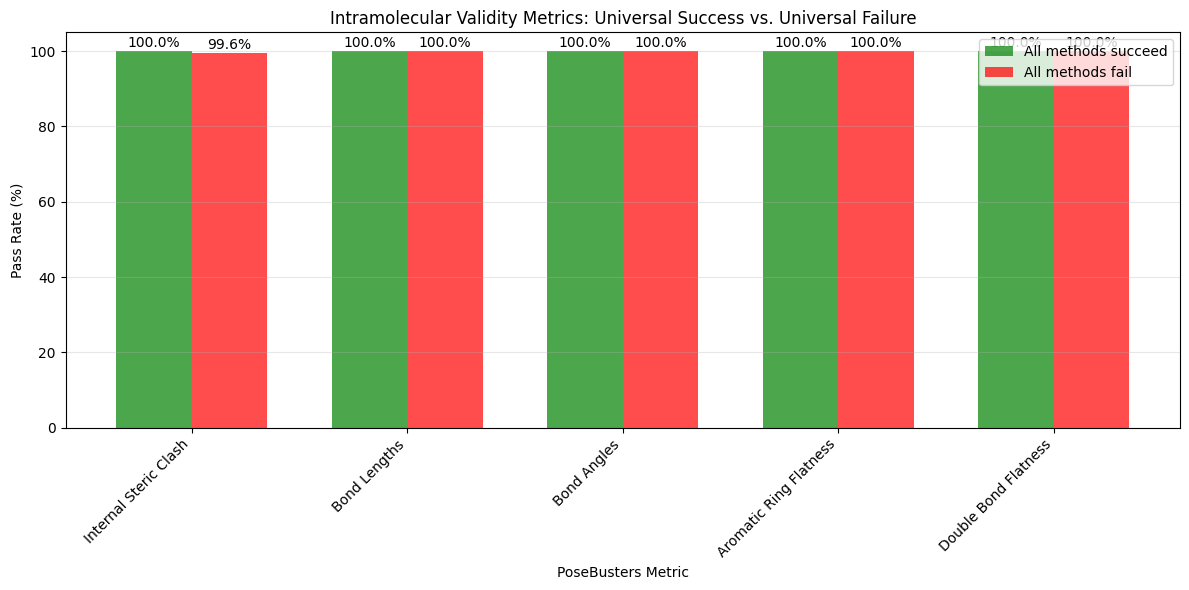

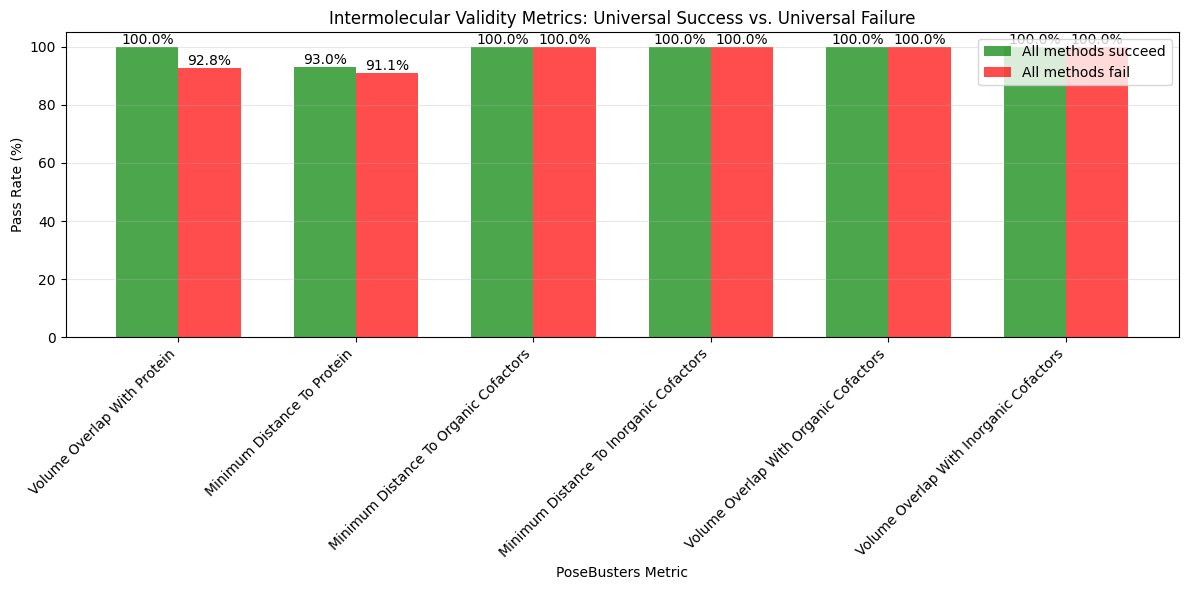

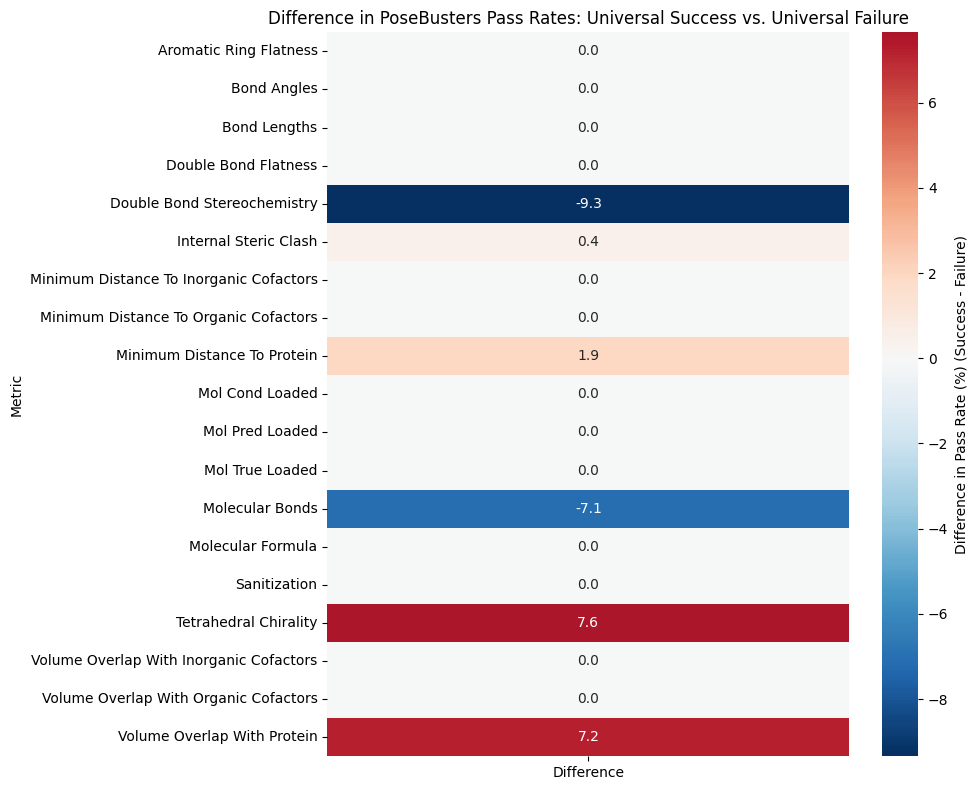


No statistically significant differences found in PoseBusters metrics.


In [6]:
# List of methods to include in analysis
methods = ['vina', 'icm']

# Run the universal analysis
universal_results = analysis.analyze_universal(
    methods=methods,
    rmsd_threshold=2.0,
    plot=True
)

# Access key results
success_proteins = universal_results['all_success_proteins']
failure_proteins = universal_results['all_failure_proteins']
significant_metrics = universal_results['significant_metrics']

#### ML-based

Analyzing PoseBusters metrics for 92 cases where all methods succeed
and 38 cases where all methods fail


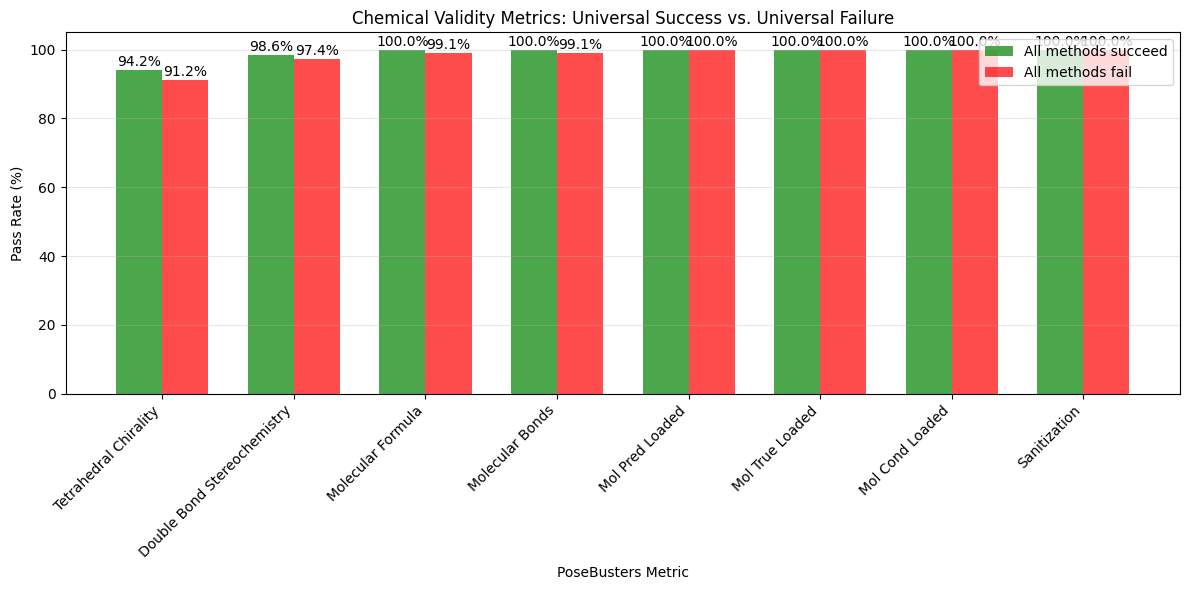

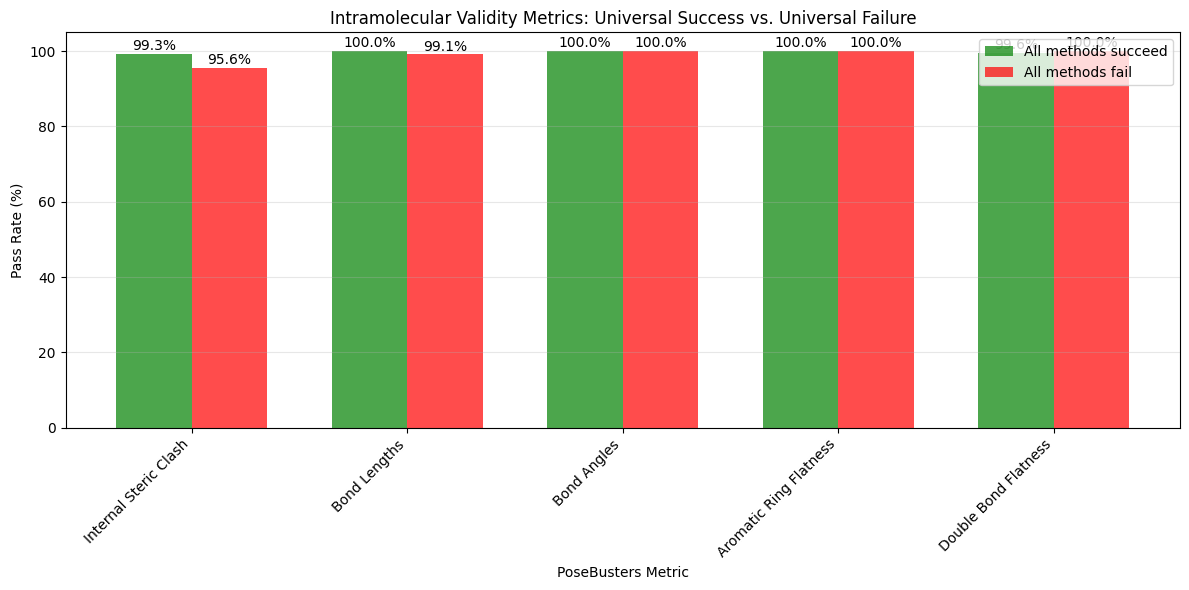

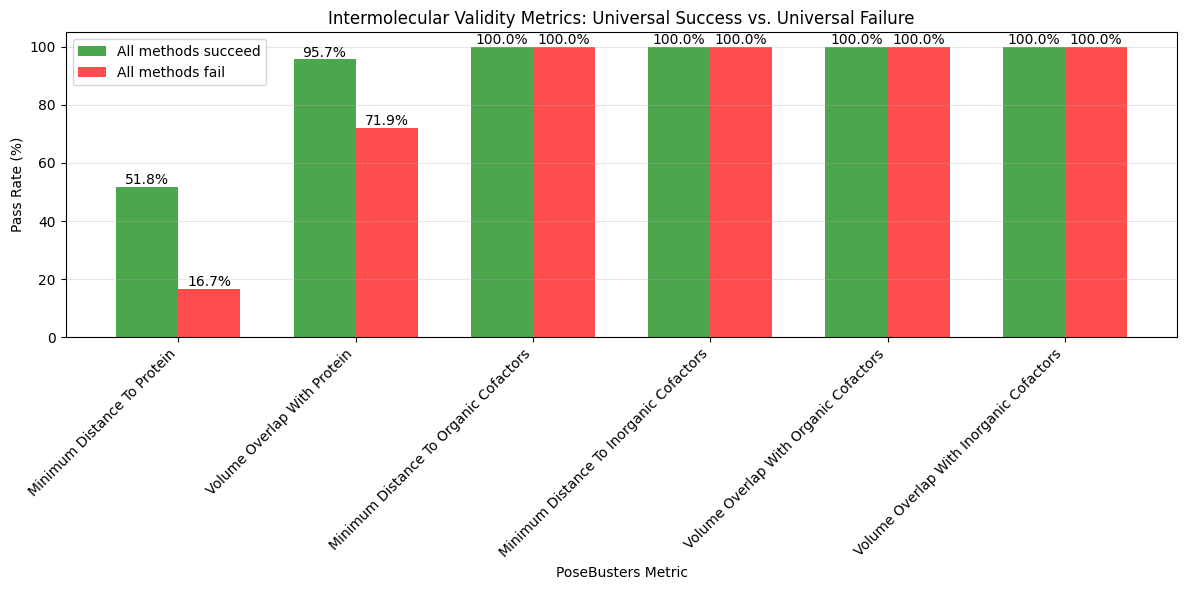

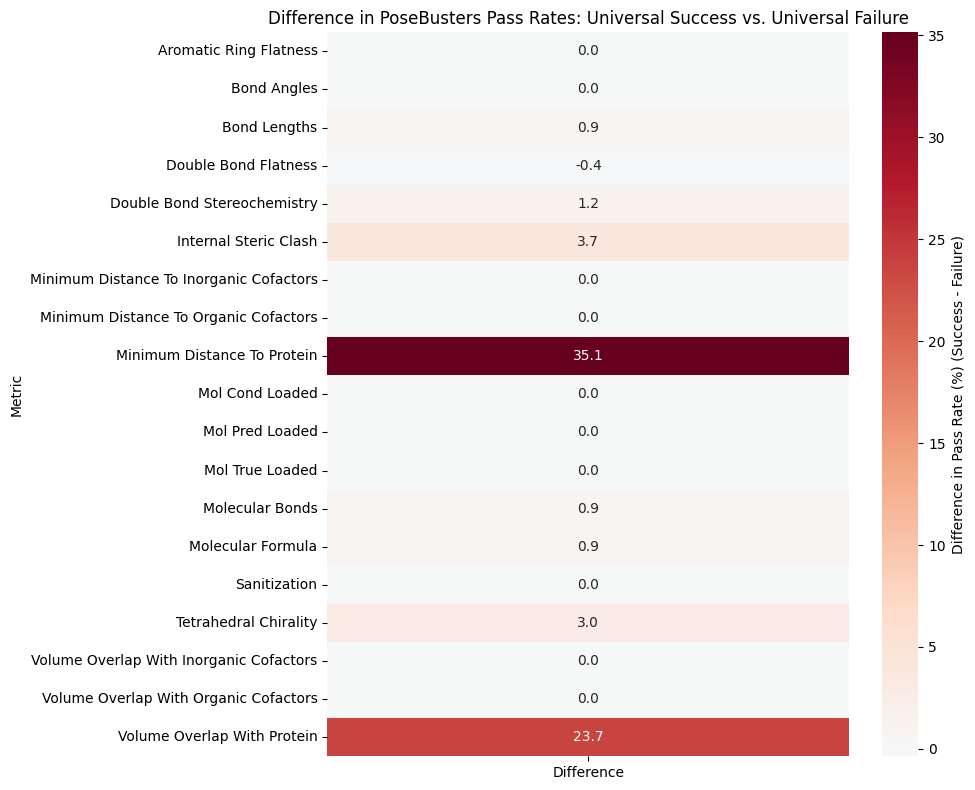


No statistically significant differences found in PoseBusters metrics.


In [7]:
# List of methods to include in analysis
methods = ['diffdock_pocket_only', 'chai-1', 'surfdock',]

# Run the universal analysis
universal_results = analysis.analyze_universal(
    methods=methods,
    rmsd_threshold=2.0,
    plot=True
)

# Access key results
success_proteins = universal_results['all_success_proteins']
failure_proteins = universal_results['all_failure_proteins']
significant_metrics = universal_results['significant_metrics']

## Individual

### ICM

Method: icm
Total proteins: 551
Success rate (RMSD ≤ 2.0Å): 71.14%


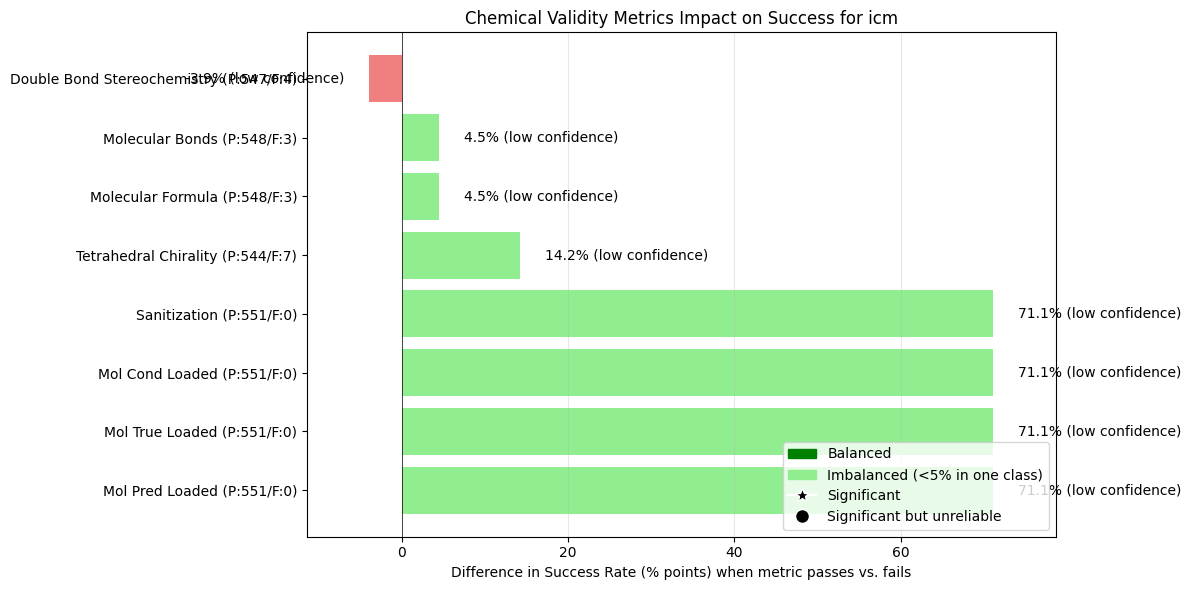

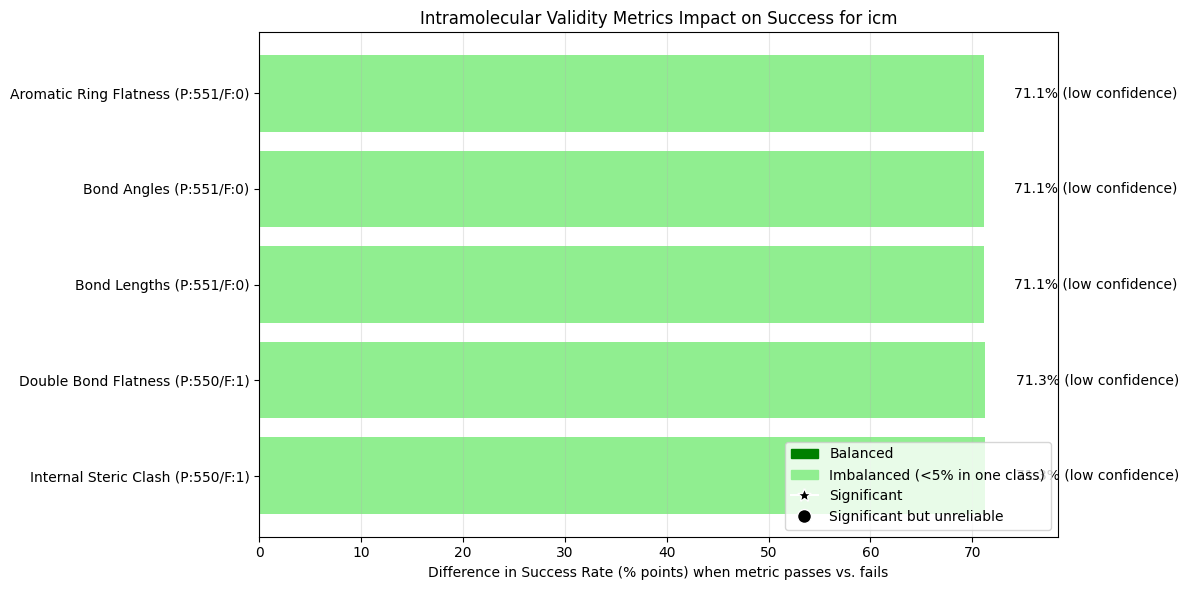

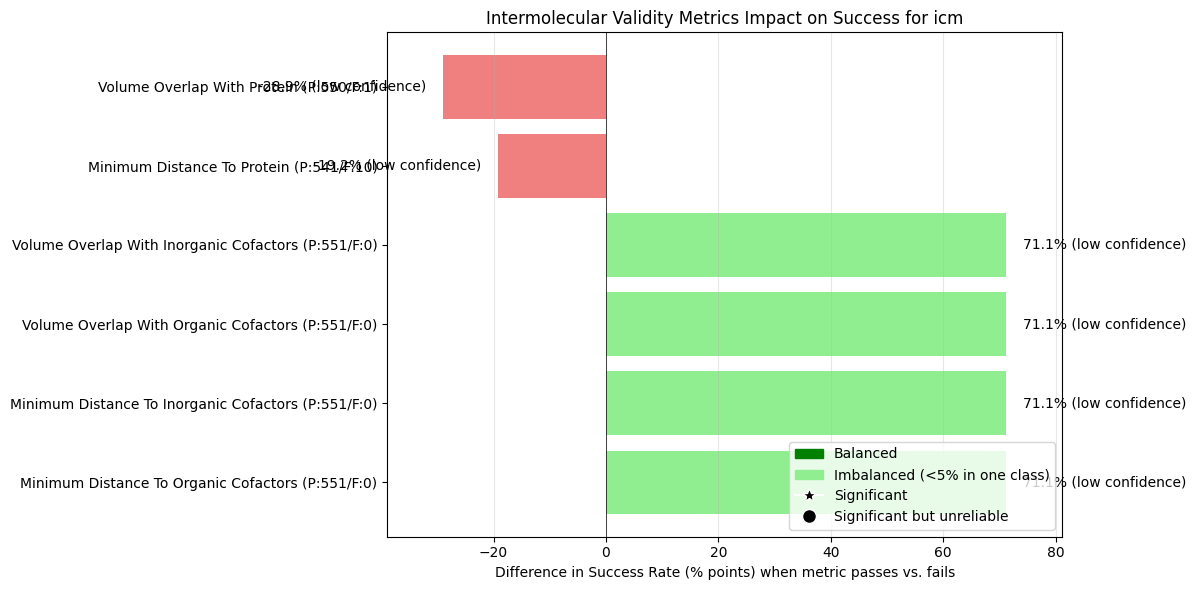


Metrics with significant impact on success rate:

Chemical Validity: No significant metrics found

Intramolecular Validity: No significant metrics found

Intermolecular Validity: No significant metrics found

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 3 samples (0.54%) fail this metric
- molecular_bonds: Only 3 samples (0.54%) fail this metric
- tetrahedral_chirality: Only 7 samples (1.27%) fail this metric
- double_bond_stereochemistry: Only 4 samples (0.73%) fail this metric
- bond_lengths: Only 0 samples (0.00%) fail this metric
- bond_angles: Only 0 samples (0.00%) fail this metric
- internal_steric_clash: Only 1 samples (0.18%) fail this metric
- aromatic_ring_flatness: Only 0 samples (0

In [8]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="icm",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

### gnina

Method: gnina
Total proteins: 562
Success rate (RMSD ≤ 2.0Å): 75.62%


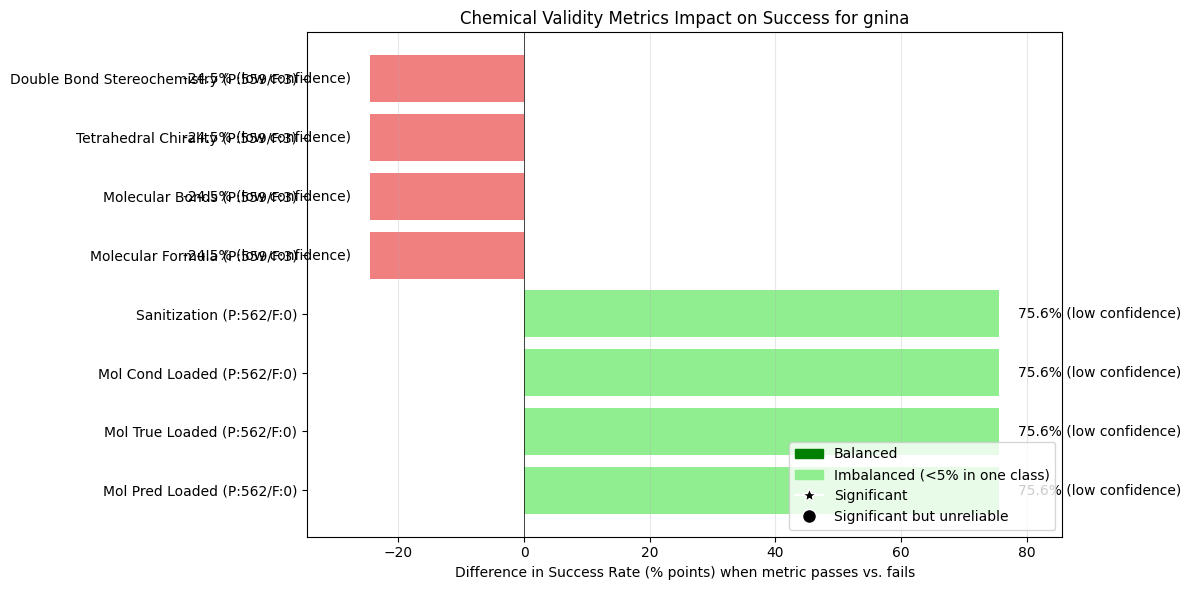

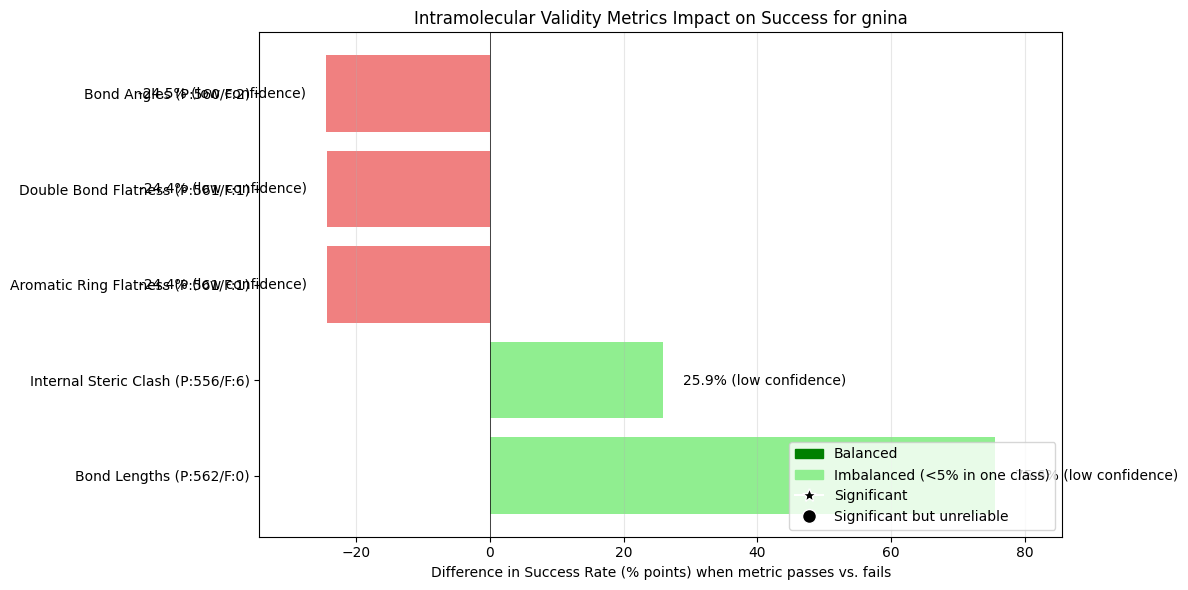

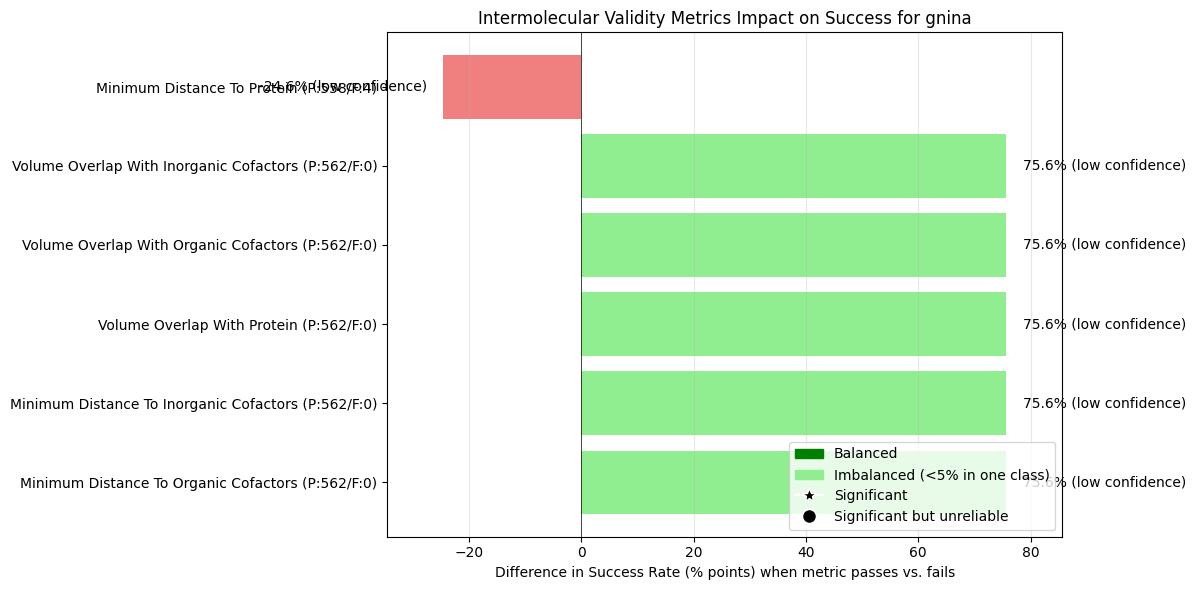


Metrics with significant impact on success rate:

Chemical Validity: No significant metrics found

Intramolecular Validity: No significant metrics found

Intermolecular Validity: No significant metrics found

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 3 samples (0.53%) fail this metric
- molecular_bonds: Only 3 samples (0.53%) fail this metric
- tetrahedral_chirality: Only 3 samples (0.53%) fail this metric
- double_bond_stereochemistry: Only 3 samples (0.53%) fail this metric
- bond_lengths: Only 0 samples (0.00%) fail this metric
- bond_angles: Only 2 samples (0.36%) fail this metric
- internal_steric_clash: Only 6 samples (1.07%) fail this metric
- aromatic_ring_flatness: Only 1 samples (0

In [9]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="gnina",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

### vina

Method: vina
Total proteins: 360
Success rate (RMSD ≤ 2.0Å): 18.33%


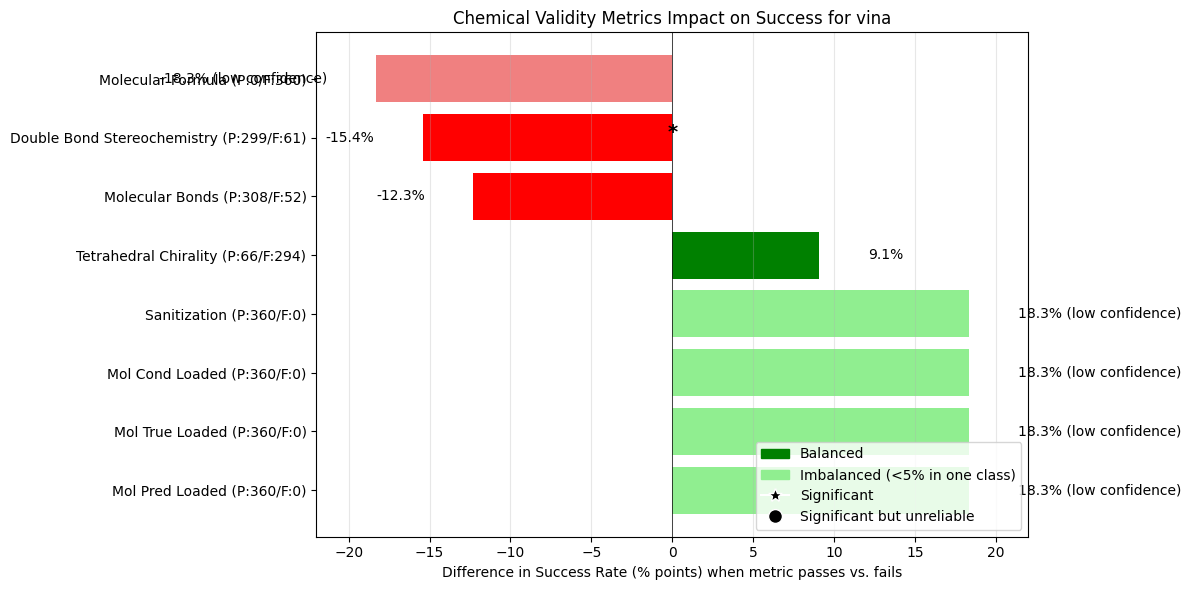

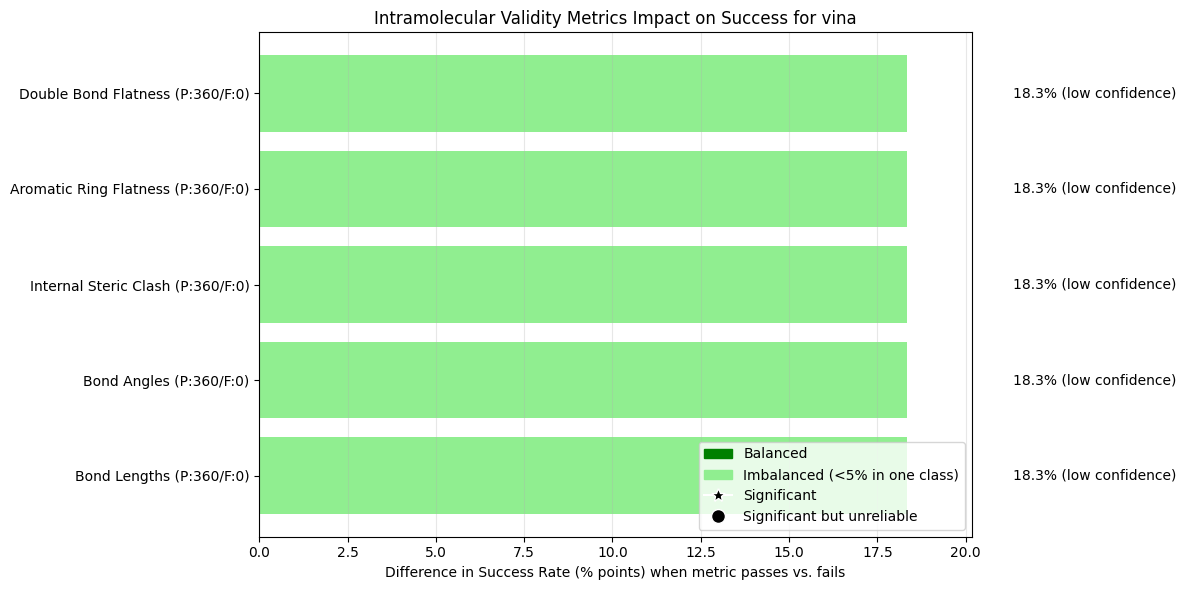

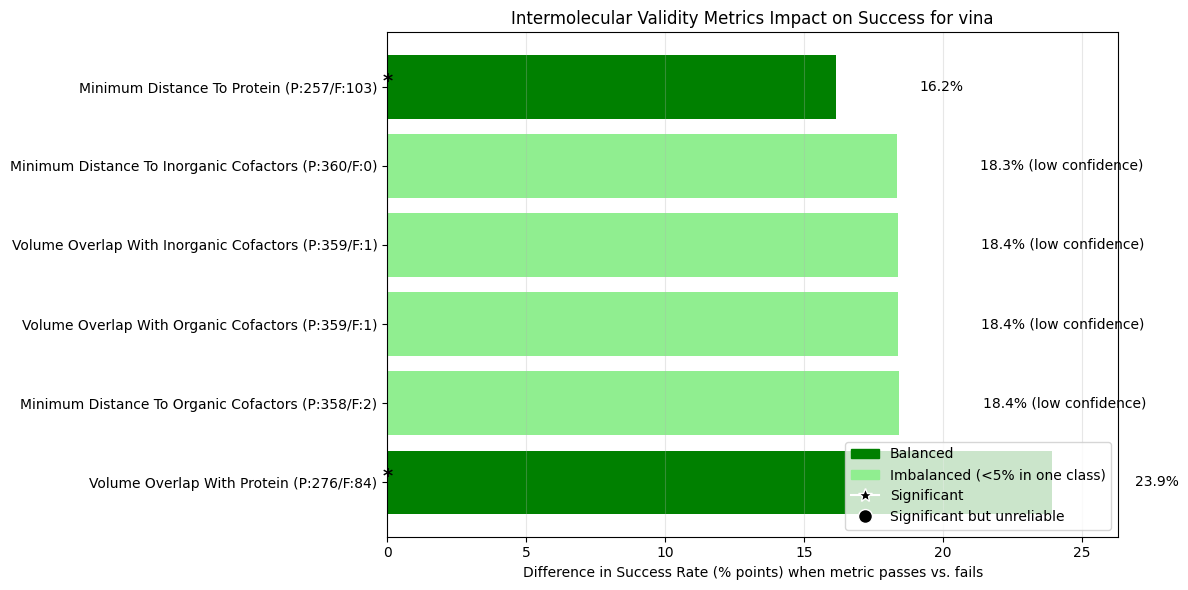


Metrics with significant impact on success rate:

Chemical Validity:
- double_bond_stereochemistry: Success rate 15.7% when pass vs. 31.1% when fail (diff: -15.4%, p=0.0100, pass/fail counts: 299/61)

Intramolecular Validity: No significant metrics found

Intermolecular Validity:
- minimum_distance_to_protein: Success rate 23.0% when pass vs. 6.8% when fail (diff: 16.2%, p=0.0002, pass/fail counts: 257/103)
- volume_overlap_with_protein: Success rate 23.9% when pass vs. 0.0% when fail (diff: 23.9%, p=0.0000, pass/fail counts: 276/84)

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 0 samples (0.00%) pass this metric
- bond_lengths: Only 0 samples (0.00%) fail this metric
- bond_angles: Only 0 samp

In [10]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="vina",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

### surfdock

Method: surfdock
Total proteins: 370
Success rate (RMSD ≤ 2.0Å): 79.46%


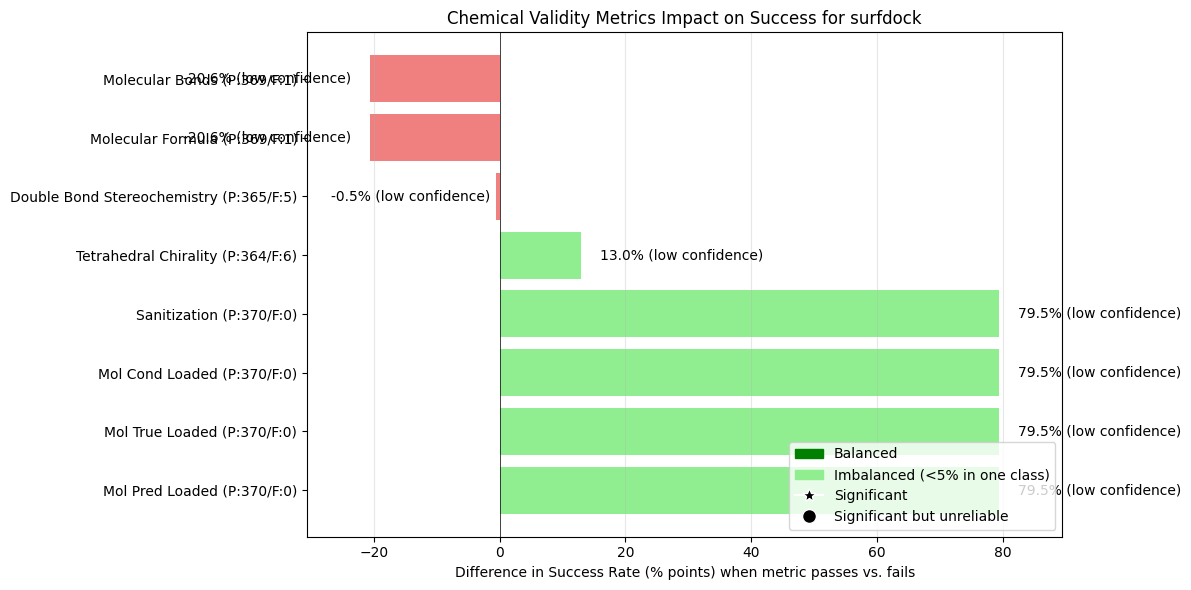

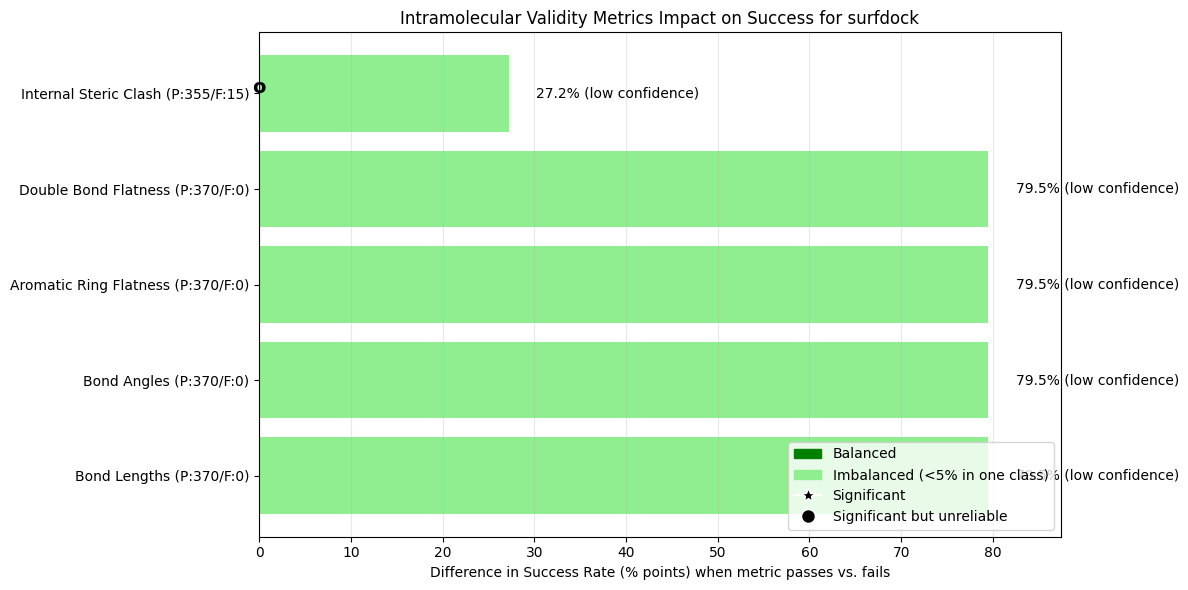

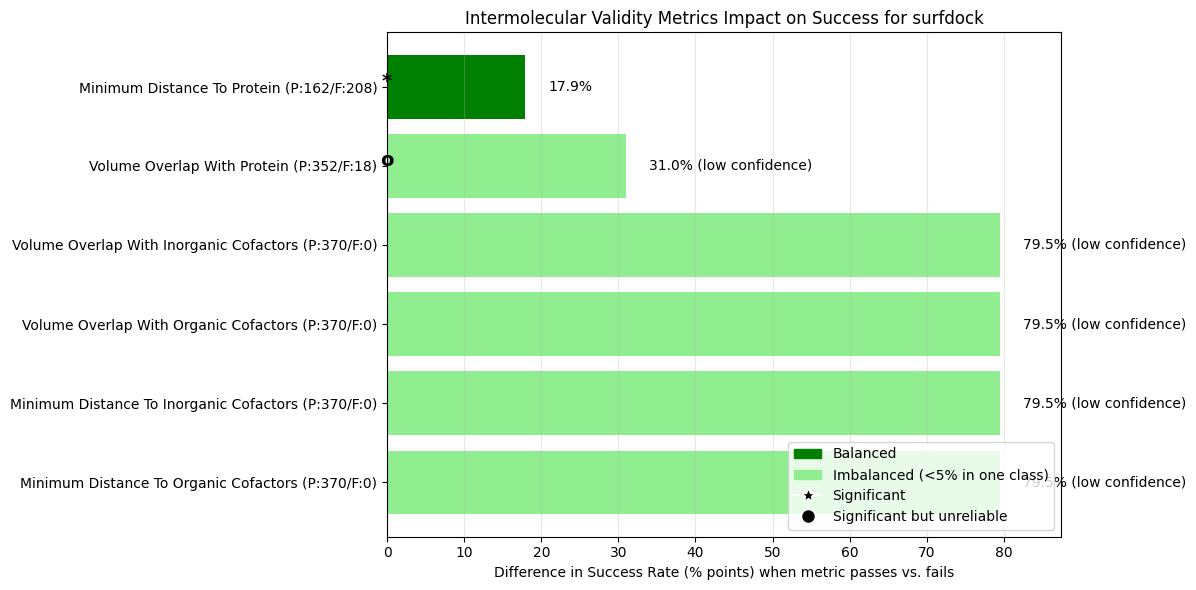


Metrics with significant impact on success rate:

Chemical Validity: No significant metrics found

Intramolecular Validity:
- internal_steric_clash: Success rate 80.6% when pass vs. 53.3% when fail (diff: 27.2%, p=0.0186, pass/fail counts: 355/15) (LOW CONFIDENCE due to imbalance)

Intermolecular Validity:
- minimum_distance_to_protein: Success rate 89.5% when pass vs. 71.6% when fail (diff: 17.9%, p=0.0000, pass/fail counts: 162/208)
- volume_overlap_with_protein: Success rate 81.0% when pass vs. 50.0% when fail (diff: 31.0%, p=0.0041, pass/fail counts: 352/18) (LOW CONFIDENCE due to imbalance)

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 1 samples (0.27%) fail this metric
- molecular_bonds: 

In [11]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="surfdock",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

### diffdock_pocket_only

Method: diffdock_pocket_only
Total proteins: 531
Success rate (RMSD ≤ 2.0Å): 50.47%


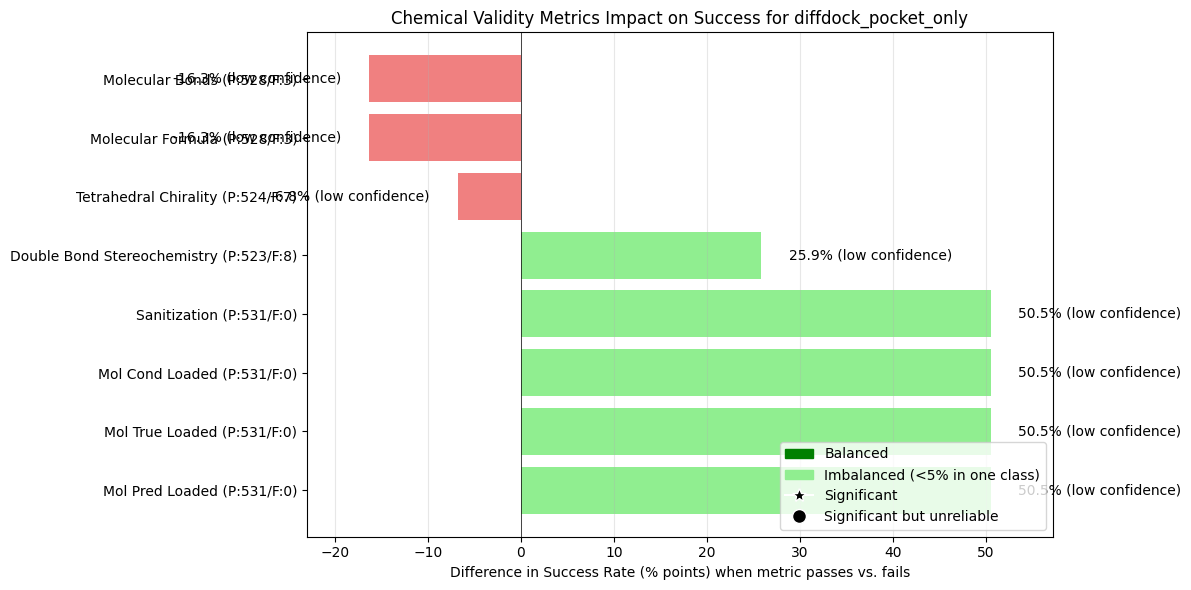

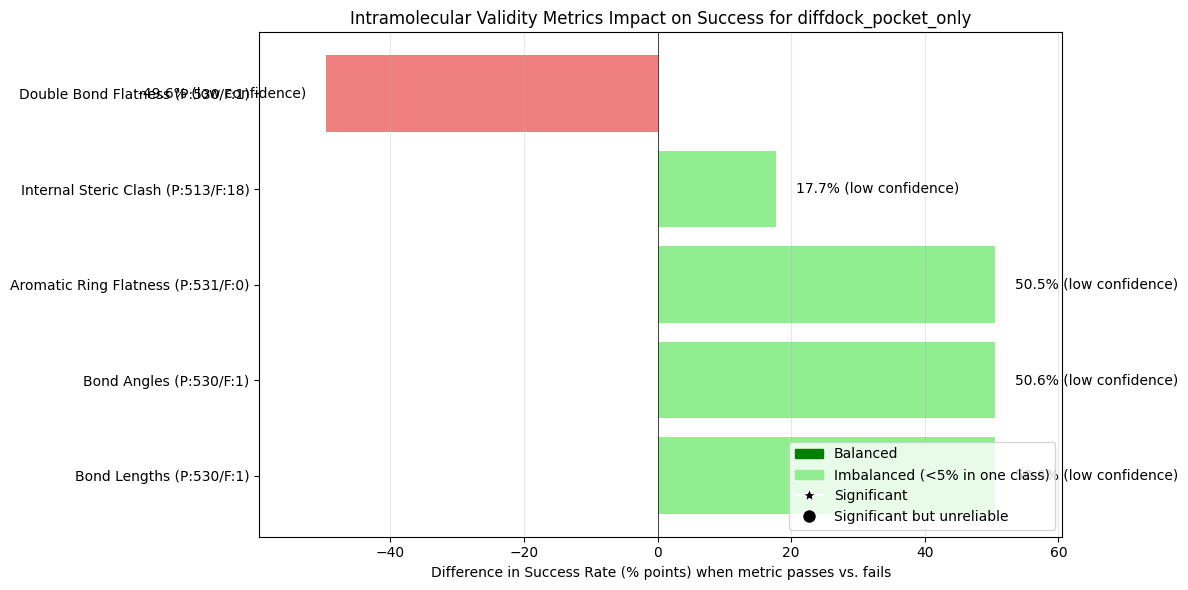

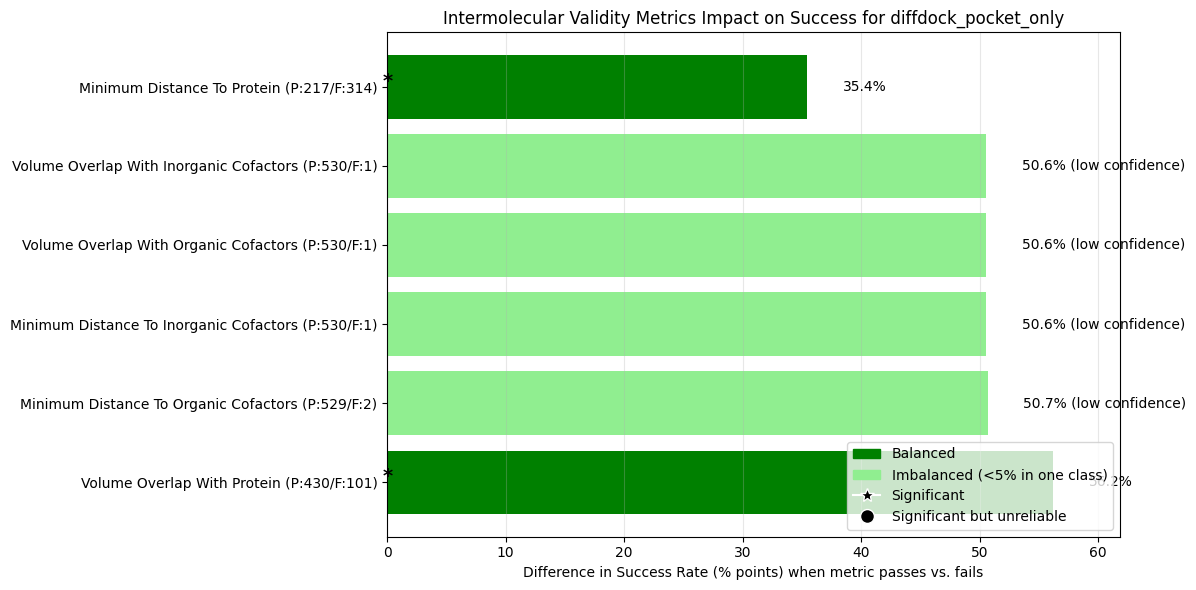


Metrics with significant impact on success rate:

Chemical Validity: No significant metrics found

Intramolecular Validity: No significant metrics found

Intermolecular Validity:
- minimum_distance_to_protein: Success rate 71.4% when pass vs. 36.0% when fail (diff: 35.4%, p=0.0000, pass/fail counts: 217/314)
- volume_overlap_with_protein: Success rate 61.2% when pass vs. 5.0% when fail (diff: 56.2%, p=0.0000, pass/fail counts: 430/101)

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 3 samples (0.56%) fail this metric
- molecular_bonds: Only 3 samples (0.56%) fail this metric
- tetrahedral_chirality: Only 7 samples (1.32%) fail this metric
- double_bond_stereochemistry: Only 8 samples (1.51%) fail

In [12]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="diffdock_pocket_only",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

### chai-1

Method: chai-1
Total proteins: 523
Success rate (RMSD ≤ 2.0Å): 45.70%


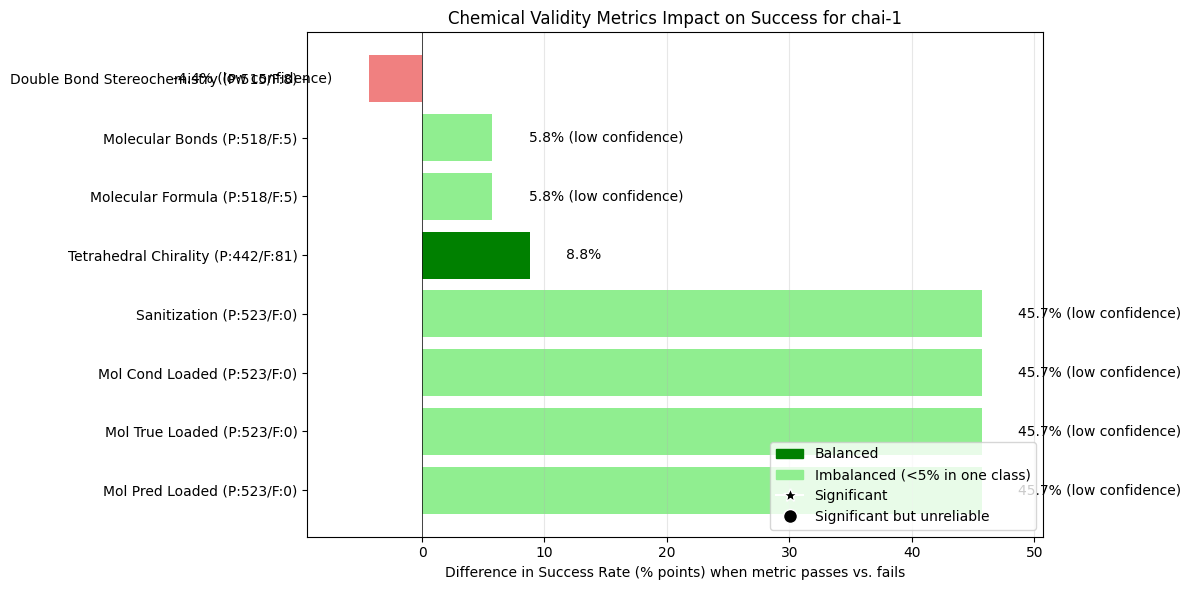

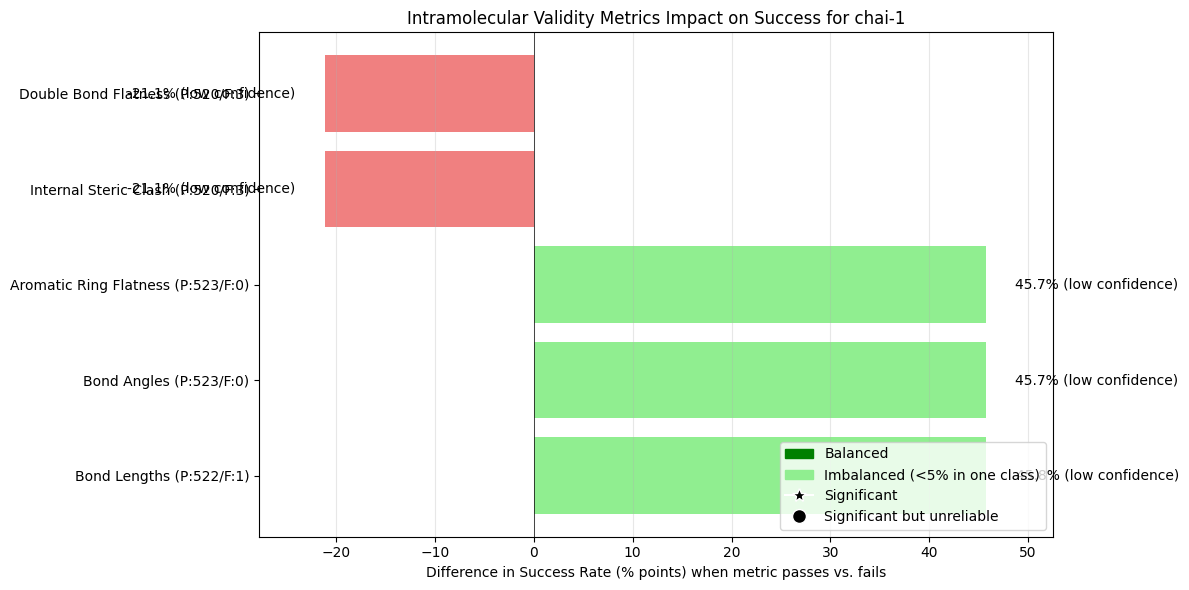

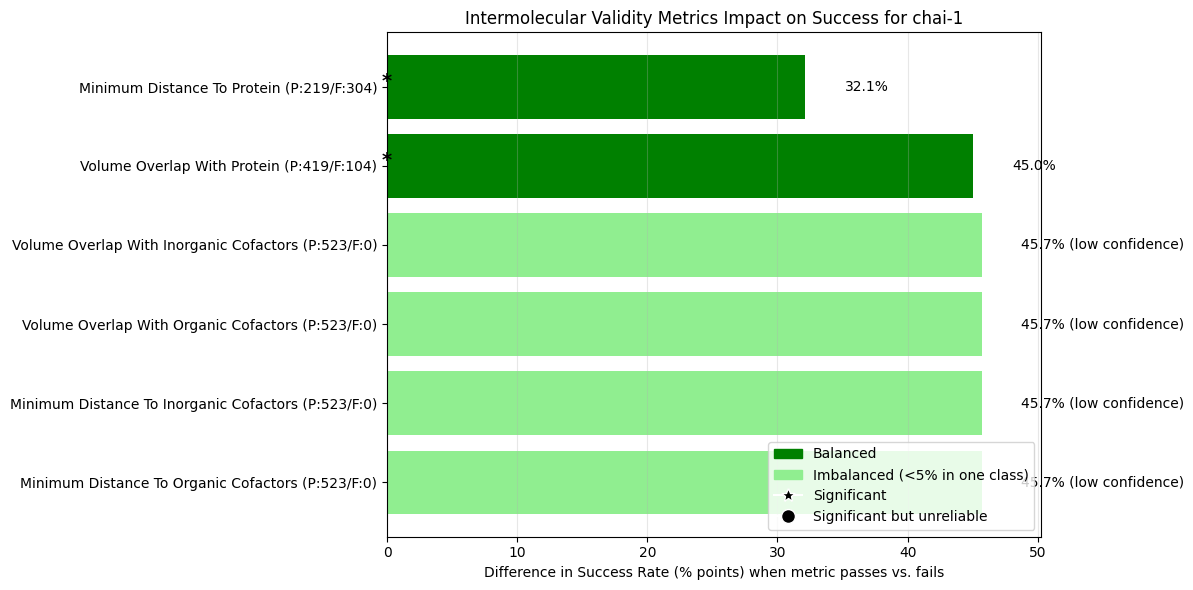


Metrics with significant impact on success rate:

Chemical Validity: No significant metrics found

Intramolecular Validity: No significant metrics found

Intermolecular Validity:
- minimum_distance_to_protein: Success rate 64.4% when pass vs. 32.2% when fail (diff: 32.1%, p=0.0000, pass/fail counts: 219/304)
- volume_overlap_with_protein: Success rate 54.7% when pass vs. 9.6% when fail (diff: 45.0%, p=0.0000, pass/fail counts: 419/104)

Note: The following metrics have severe class imbalance (one class < 5% of data):
- mol_pred_loaded: Only 0 samples (0.00%) fail this metric
- mol_true_loaded: Only 0 samples (0.00%) fail this metric
- mol_cond_loaded: Only 0 samples (0.00%) fail this metric
- sanitization: Only 0 samples (0.00%) fail this metric
- molecular_formula: Only 5 samples (0.96%) fail this metric
- molecular_bonds: Only 5 samples (0.96%) fail this metric
- double_bond_stereochemistry: Only 8 samples (1.53%) fail this metric
- bond_lengths: Only 1 samples (0.19%) fail this met

In [13]:
# Analyze a single method with default RMSD threshold of 2.0Å
single_method_results = analysis.analyze_single_method(
    method="chai-1",
    rmsd_threshold=2.0,
    imbalance_threshold=0.05,
    plot=True  # Generate visualization plots
)

# Access the results
success_rate = single_method_results['overall_success_rate']
significant_metrics = single_method_results['significant_metrics']

## Comparative 

Analyzing PoseBusters metrics for 33 cases where diffdock_pocket_only succeeds but icm fails
and 143 cases where icm succeeds but diffdock_pocket_only fails


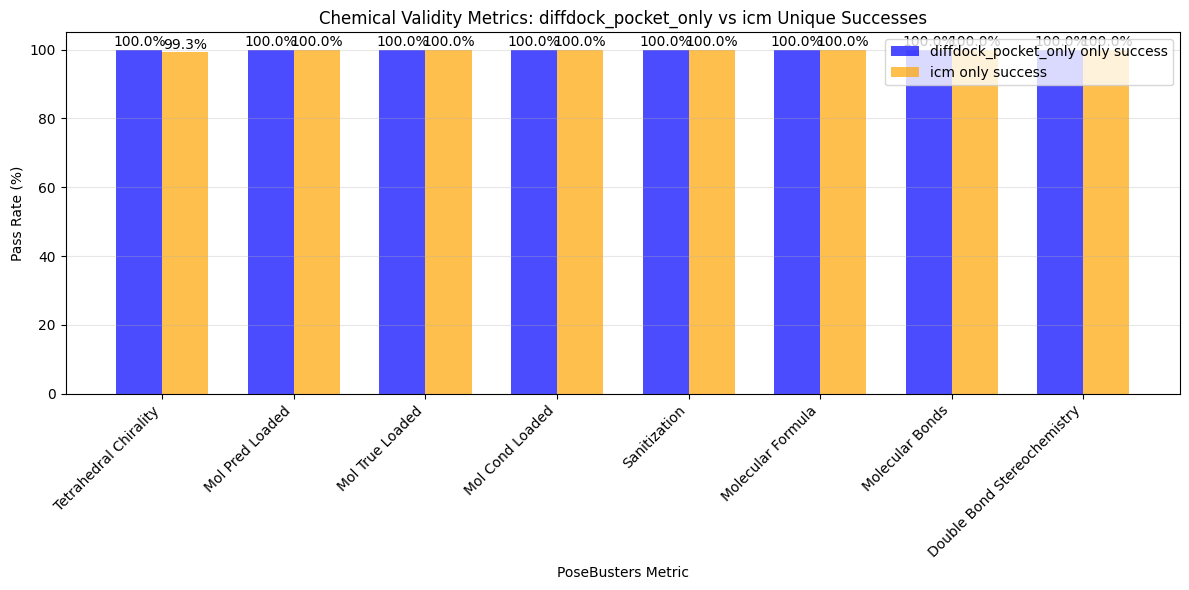

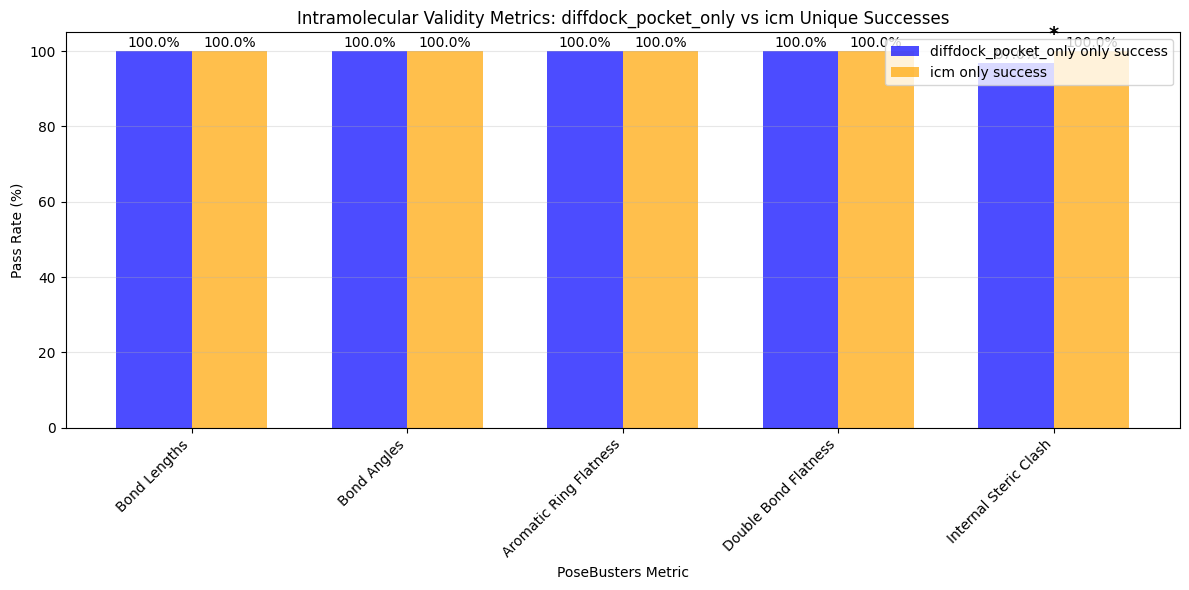

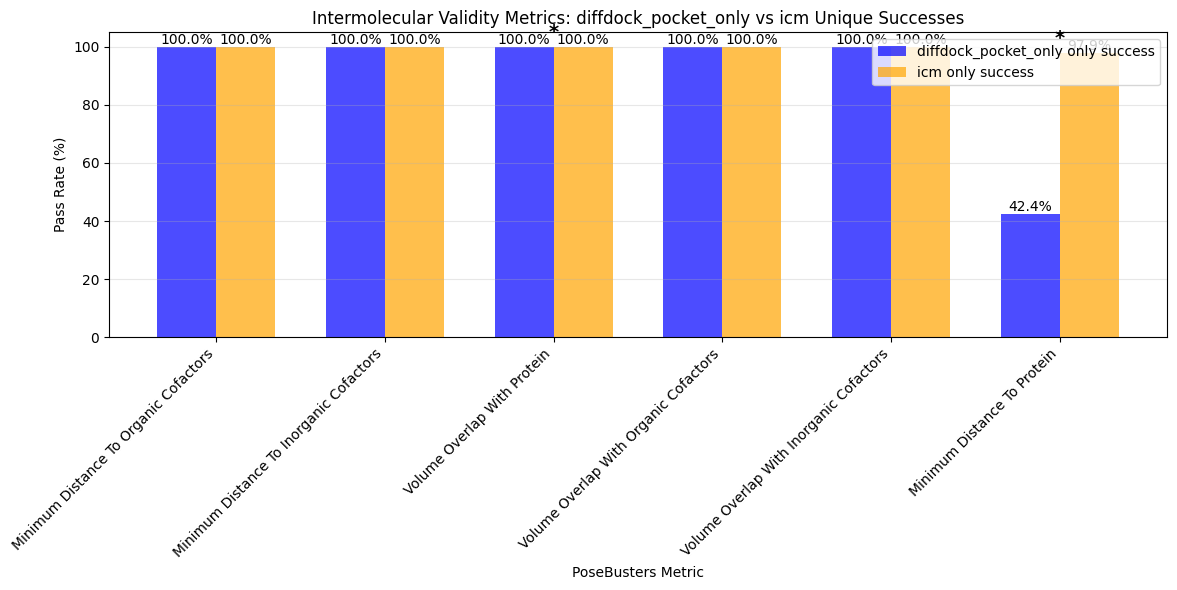

NameError: name 'LinearSegmentedColormap' is not defined

<Figure size 1200x800 with 0 Axes>

In [14]:
comparative_results = analysis.analyze_comparative(
    method1="diffdock_pocket_only",
    method2="icm",
    rmsd_threshold=2.0,
    plot=True
)

# Access results
method1_only = comparative_results['method1_only_proteins']
method2_only = comparative_results['method2_only_proteins']
significant_metrics = comparative_results['significant_metrics']

Comparing 3 ML-based methods vs. 2 Physics-based methods
ML-based methods: diffdock_pocket_only, surfdock, chai-1
Physics-based methods: gnina, icm


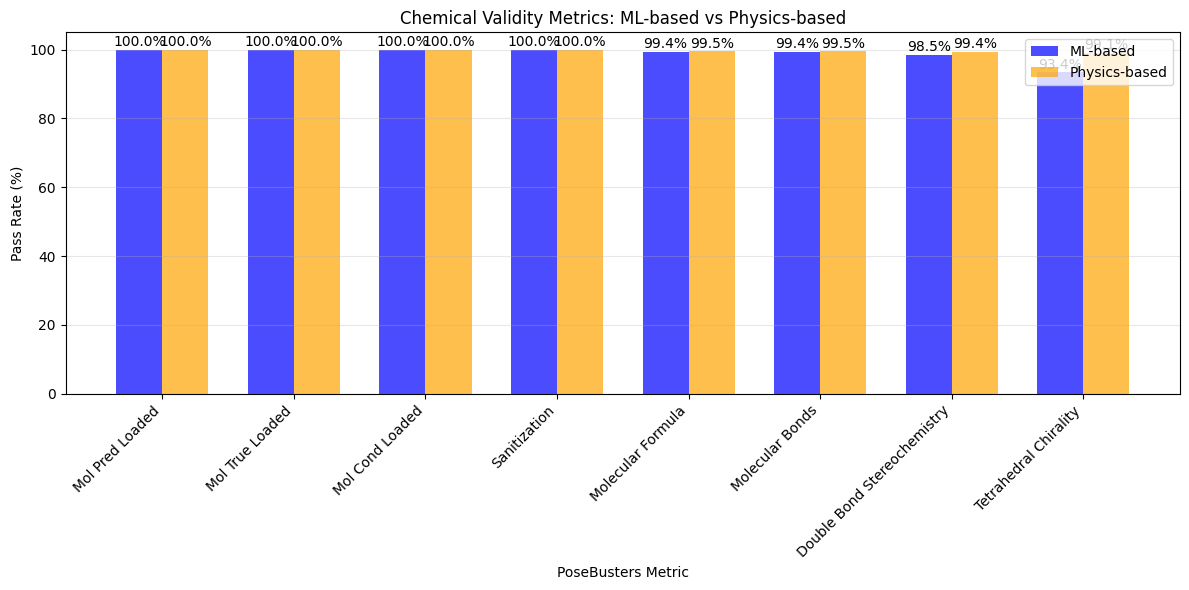

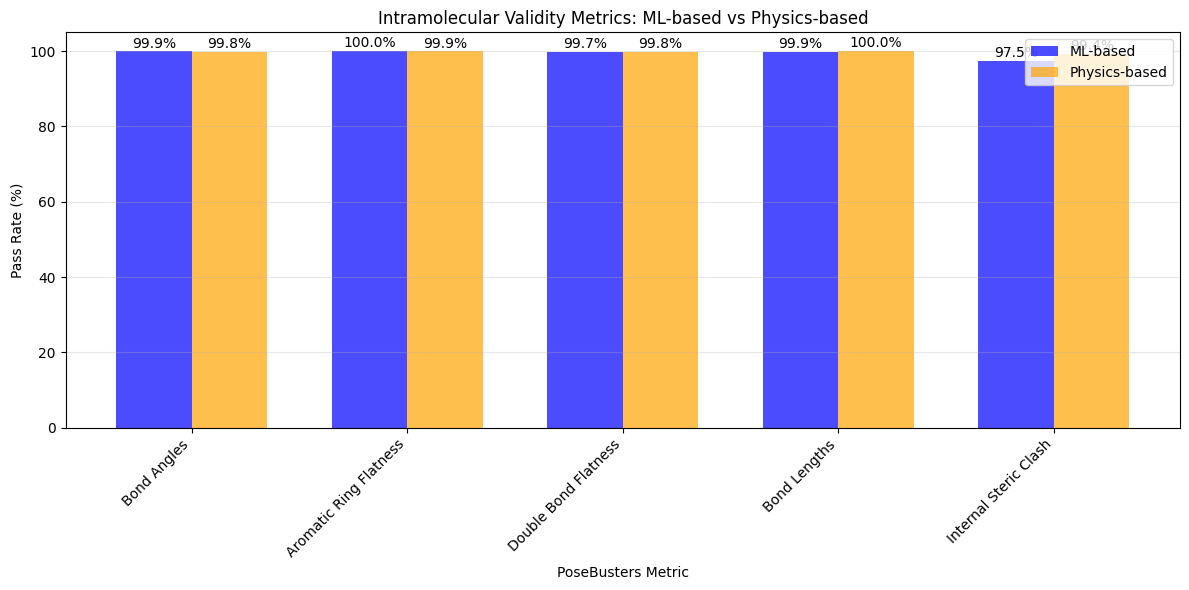

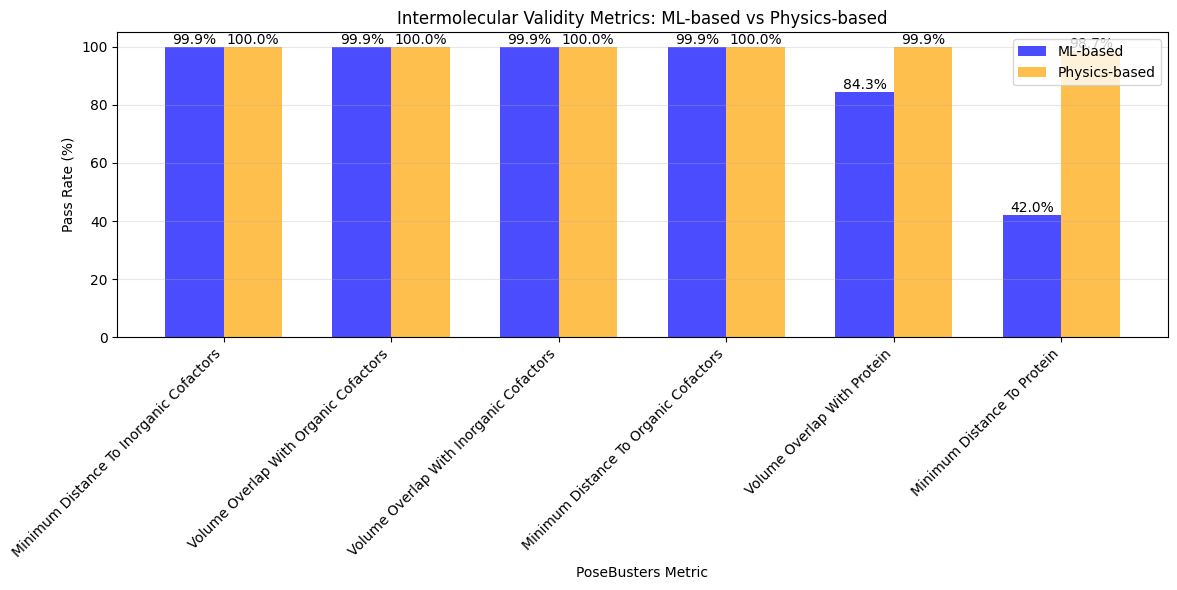

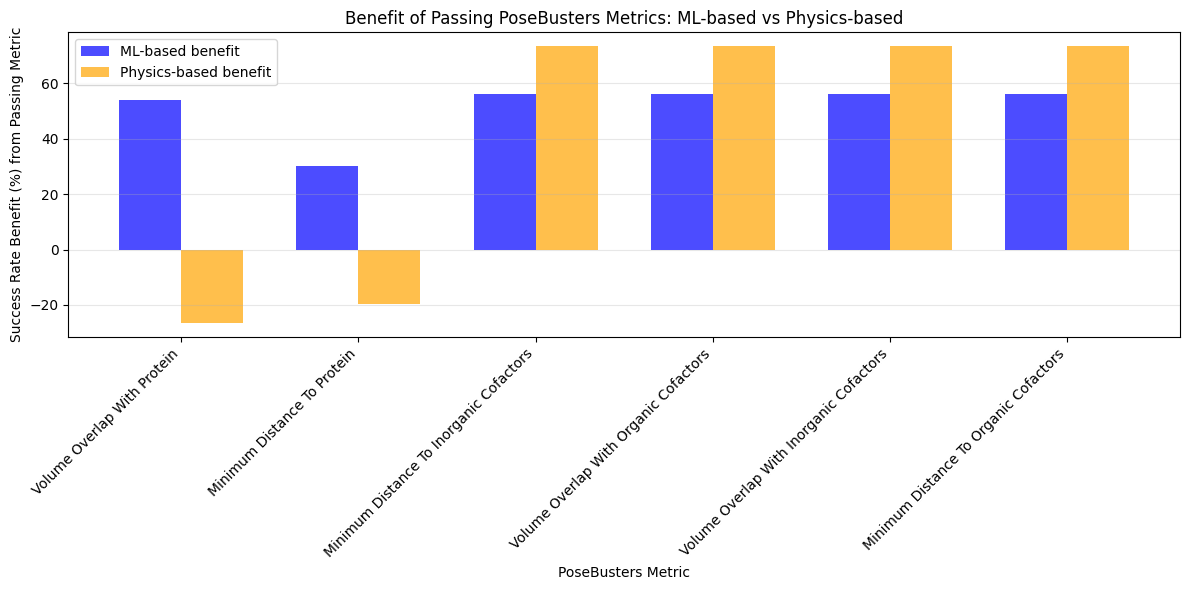

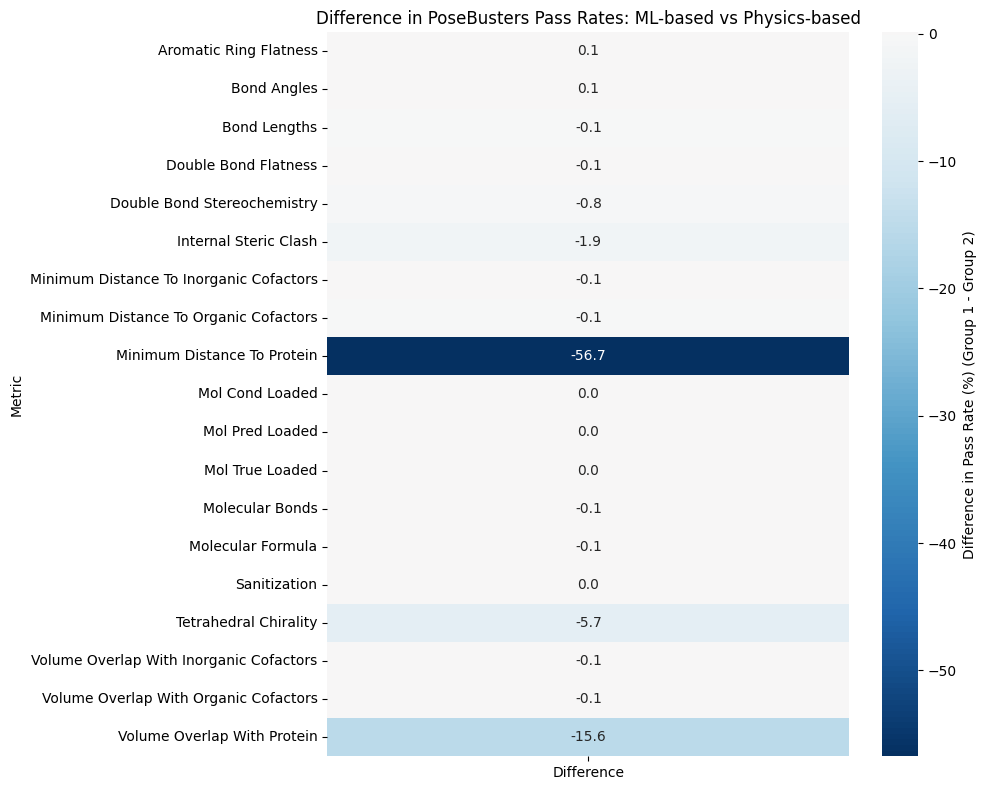


No statistically significant differences found in PoseBusters metrics between method groups.

How PoseBusters metrics affect success rates within groups:

Chemical Validity:
- mol_pred_loaded:
  ML-based: Success rate 56.2% when pass vs. 0.0% when fail (benefit: 56.2%)
  Physics-based: Success rate 73.4% when pass vs. 0.0% when fail (benefit: 73.4%)
  Note: Physics-based benefits more from passing this metric (difference: 17.2%)
- mol_true_loaded:
  ML-based: Success rate 56.2% when pass vs. 0.0% when fail (benefit: 56.2%)
  Physics-based: Success rate 73.4% when pass vs. 0.0% when fail (benefit: 73.4%)
  Note: Physics-based benefits more from passing this metric (difference: 17.2%)
- mol_cond_loaded:
  ML-based: Success rate 56.2% when pass vs. 0.0% when fail (benefit: 56.2%)
  Physics-based: Success rate 73.4% when pass vs. 0.0% when fail (benefit: 73.4%)
  Note: Physics-based benefits more from passing this metric (difference: 17.2%)
- sanitization:
  ML-based: Success rate 56.2% w

In [5]:
ml_methods = ['diffdock_pocket_only', 'surfdock', 'chai-1']
physics_methods = ['gnina', 'icm']

group_results = analysis.analyze_method_group_comparative(
    group1_methods=ml_methods,
    group2_methods=physics_methods,
    group1_label="ML-based",
    group2_label="Physics-based",
    rmsd_threshold=2.0,
    plot=True
)

### Comparative Mixed Effect

#### minimum_distance_to_protein

                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   outcome   
No. Observations:                    2897                      Method:                               REML      
No. Groups:                          562                       Scale:                                18.5672   
Min. group size:                     2                         Log-Likelihood:                       -8502.1512
Max. group size:                     6                         Converged:                            Yes       
Mean group size:                     5.2                                                                       
---------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------

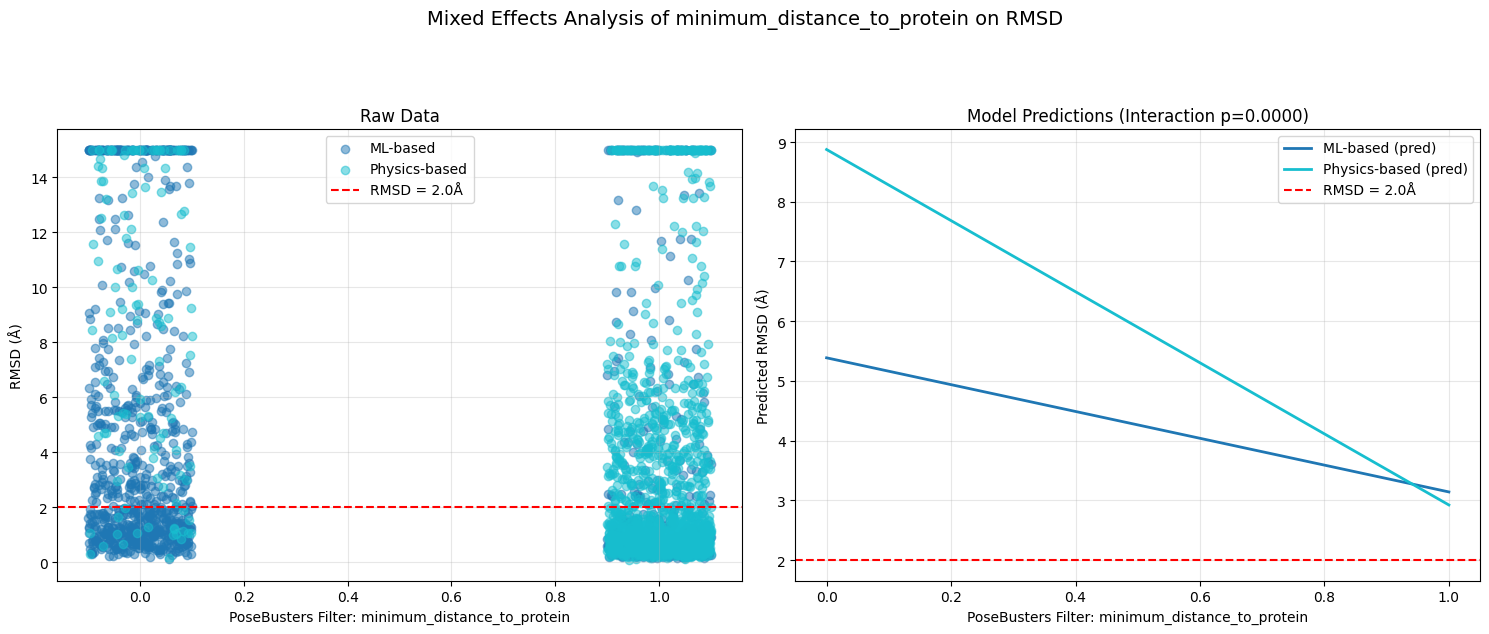

In [11]:
analysis = PoseBustersAnalysis(df_combined)
result = analysis.mixed_effect_analysis(
    filter_name='minimum_distance_to_protein',
    method_groups={
        'ML-based': ['diffdock_pocket_only', 'chai-1', 'surfdock'], 
        'Physics-based': ['vina', 'gnina', 'icm']
    },
    rmsd_threshold=2.0,
    outcome_type='rmsd',
    plot=True
)
# Access model and results
# print("Model:", result['model'].summary())
# print("Interaction p-value:", result['p_interaction'])

                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   outcome   
No. Observations:                    2897                      Method:                               REML      
No. Groups:                          562                       Scale:                                18.5672   
Min. group size:                     2                         Log-Likelihood:                       -8502.1512
Max. group size:                     6                         Converged:                            Yes       
Mean group size:                     5.2                                                                       
---------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------

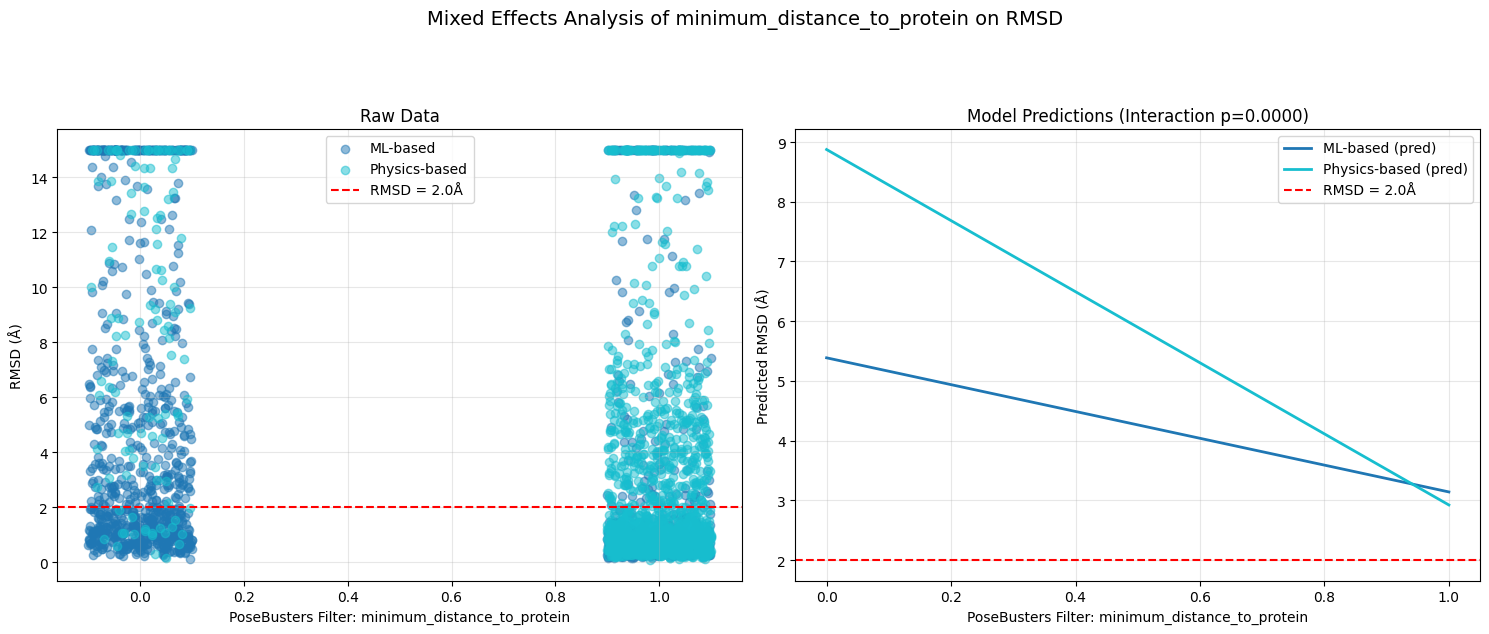

In [ ]:
result = analysis.mixed_effect_analysis(
    filter_name="minimum_distance_to_protein",
    method_groups={
        'ML-based': ['diffdock_pocket_only', 'chai-1', 'surfdock'], 
        'Physics-based': ['vina', 'icm']
    },
    rmsd_threshold=2.0,
    outcome_type='rmsd',
    plot=True
)

#### all

Property: mol_pred_loaded
Error fitting mixed effects model: Singular matrix
Property: mol_true_loaded
Error fitting mixed effects model: Singular matrix
Property: mol_cond_loaded
Error fitting mixed effects model: Singular matrix
Property: sanitization
Error fitting mixed effects model: Singular matrix
Property: molecular_formula


/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:1404: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['outcome'] = np.clip(analysis_df['rmsd'], None, 15.0)


                                Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                outcome   
No. Observations:                 2273                   Method:                            REML      
No. Groups:                       559                    Scale:                             18.6847   
Min. group size:                  1                      Log-Likelihood:                    -6724.6345
Max. group size:                  5                      Converged:                         Yes       
Mean group size:                  4.1                                                                 
------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

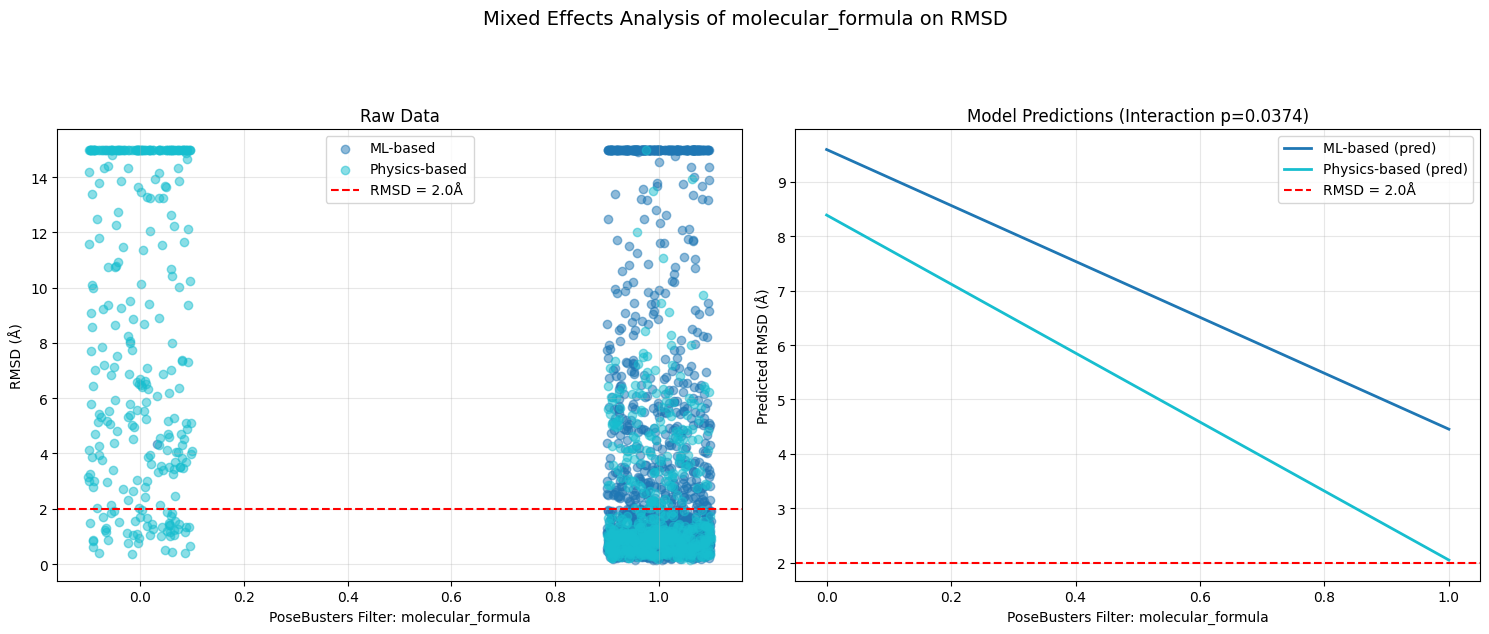

Property: molecular_bonds


/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:1404: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['outcome'] = np.clip(analysis_df['rmsd'], None, 15.0)


Error fitting mixed effects model: Singular matrix
Property: tetrahedral_chirality


/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:1404: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['outcome'] = np.clip(analysis_df['rmsd'], None, 15.0)


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 outcome   
No. Observations:                  2273                    Method:                             REML      
No. Groups:                        559                     Scale:                              19.7299   
Min. group size:                   1                       Log-Likelihood:                     -6773.3120
Max. group size:                   5                       Converged:                          Yes       
Mean group size:                   4.1                                                                   
---------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------

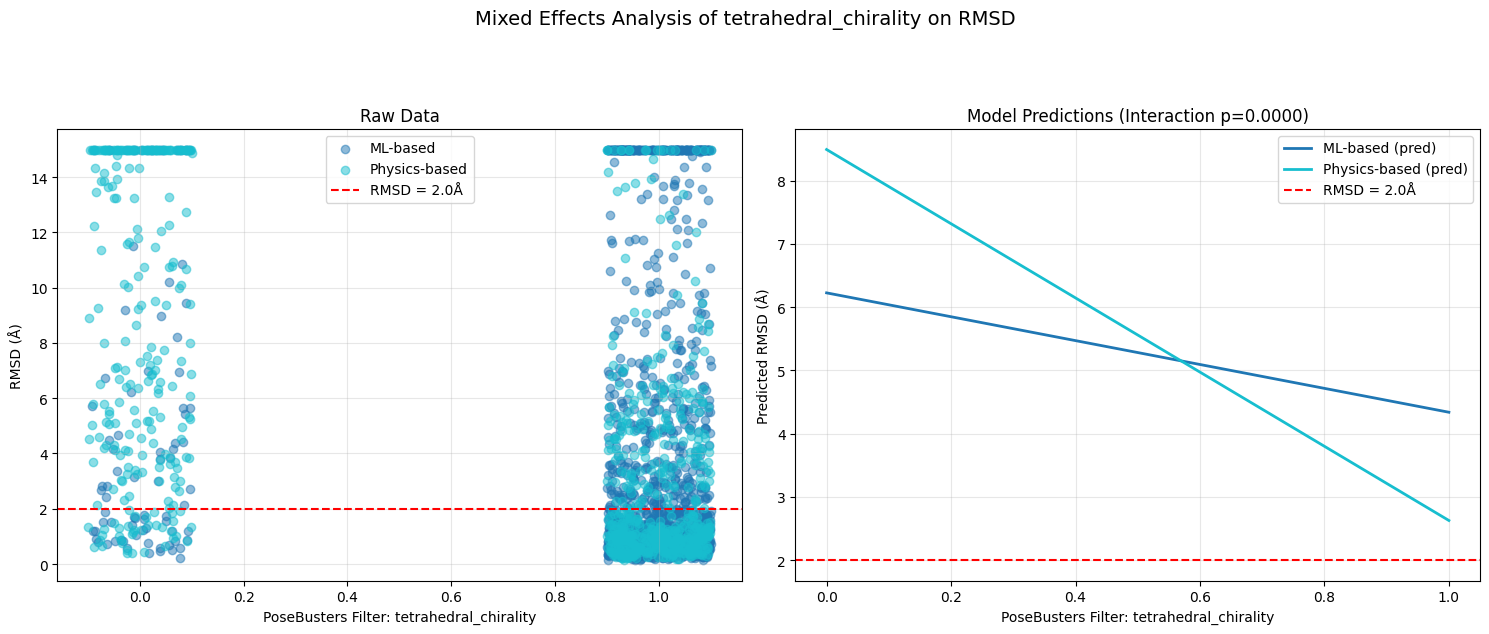

Property: double_bond_stereochemistry


/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:1404: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['outcome'] = np.clip(analysis_df['rmsd'], None, 15.0)


                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   outcome   
No. Observations:                    2273                      Method:                               REML      
No. Groups:                          559                       Scale:                                22.5103   
Min. group size:                     1                         Log-Likelihood:                       -6908.5918
Max. group size:                     5                         Converged:                            Yes       
Mean group size:                     4.1                                                                       
---------------------------------------------------------------------------------------------------------------
                                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------

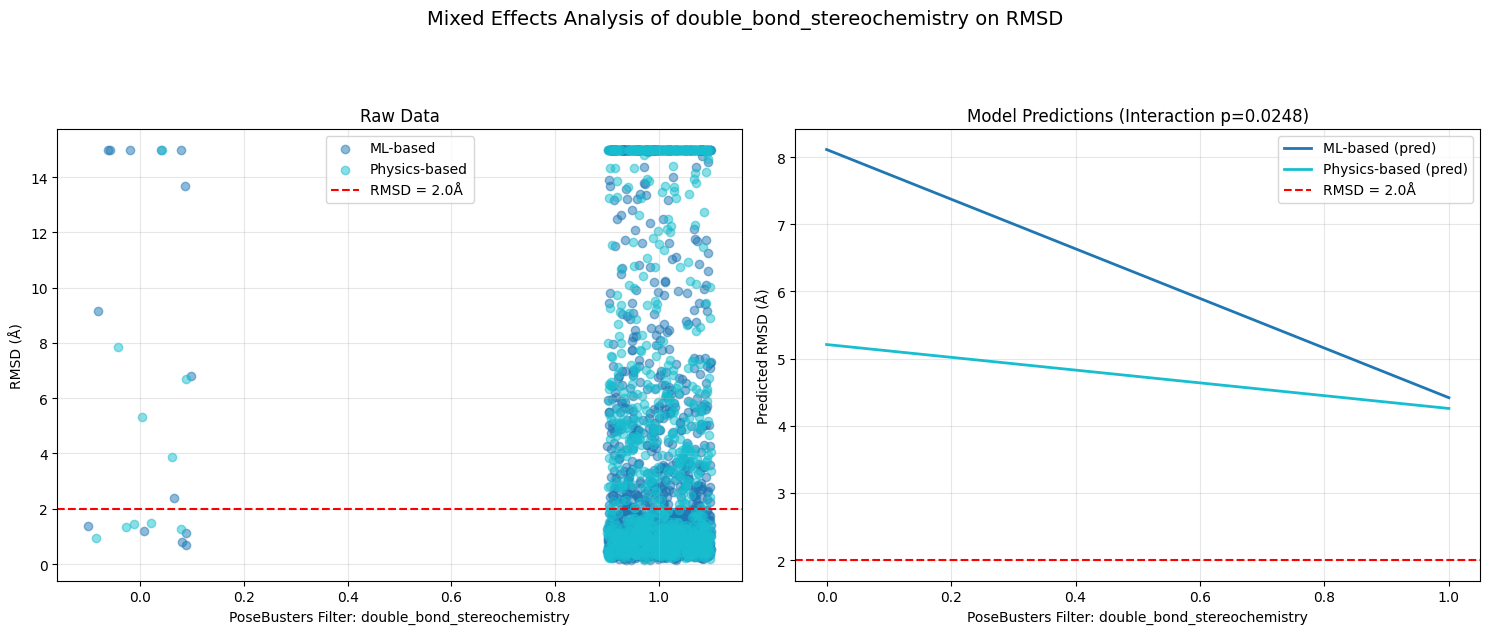

Property: bond_lengths
Error fitting mixed effects model: Singular matrix
Property: bond_angles
Error fitting mixed effects model: Singular matrix
Property: internal_steric_clash
                                  Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 outcome   
No. Observations:                   2335                    Method:                             REML      
No. Groups:                         562                     Scale:                              23.5992   
Min. group size:                    1                       Log-Likelihood:                     -7127.6276
Max. group size:                    5                       Converged:                          Yes       
Mean group size:                    4.2                                                                   
----------------------------------------------------------------------------------------------------------


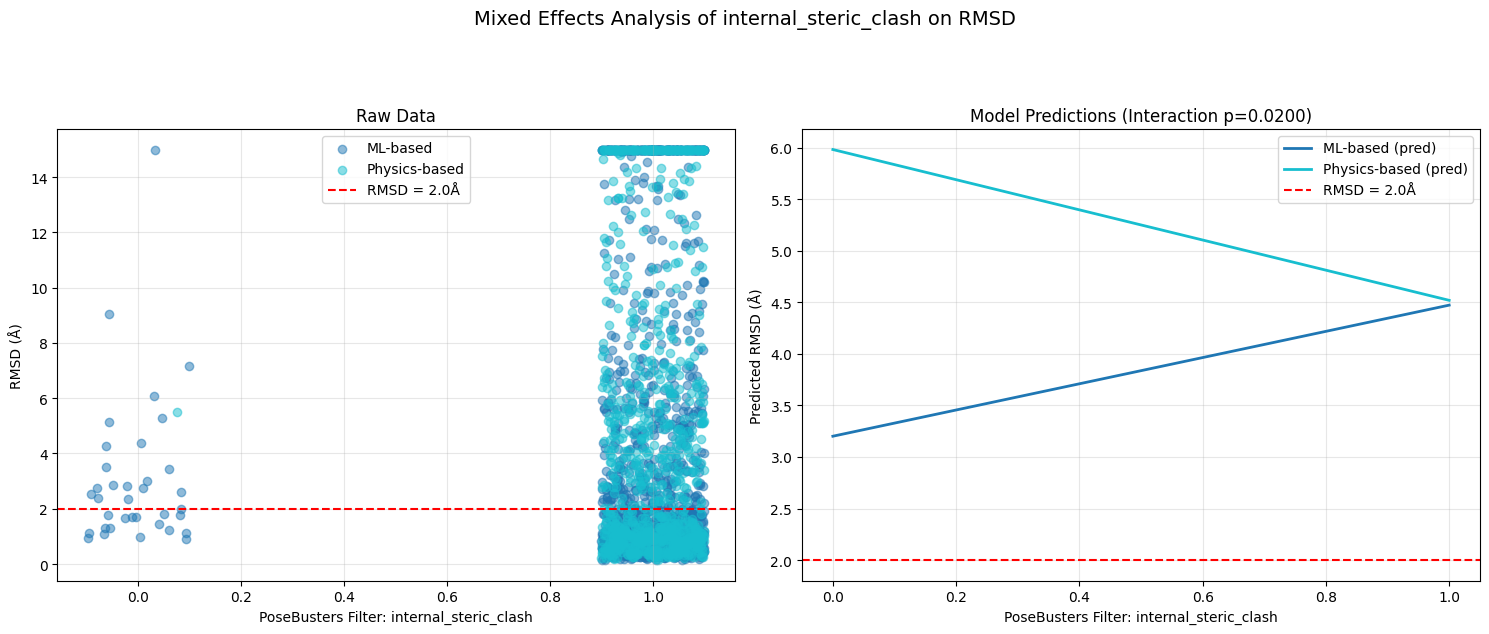

Property: aromatic_ring_flatness
Error fitting mixed effects model: Singular matrix
Property: double_bond_flatness
                                  Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 outcome   
No. Observations:                  2335                    Method:                             REML      
No. Groups:                        562                     Scale:                              23.6314   
Min. group size:                   1                       Log-Likelihood:                     -7126.4104
Max. group size:                   5                       Converged:                          Yes       
Mean group size:                   4.2                                                                   
---------------------------------------------------------------------------------------------------------
                                                              Coef.  St

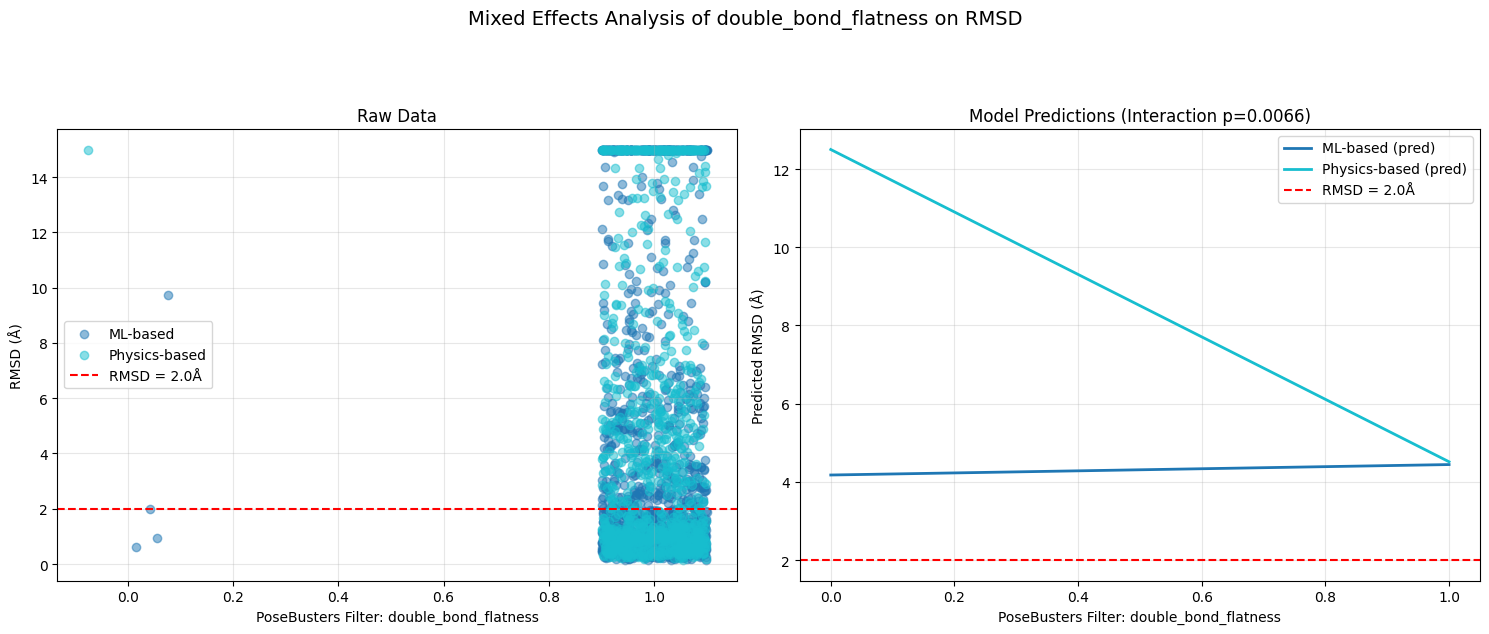

Property: internal_energy
Filter 'internal_energy' not found in available PoseBusters metrics.
Property: minimum_distance_to_protein
                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   outcome   
No. Observations:                    2335                      Method:                               REML      
No. Groups:                          562                       Scale:                                21.8573   
Min. group size:                     1                         Log-Likelihood:                       -7043.4276
Max. group size:                     5                         Converged:                            Yes       
Mean group size:                     4.2                                                                       
---------------------------------------------------------------------------------------------------------------
        

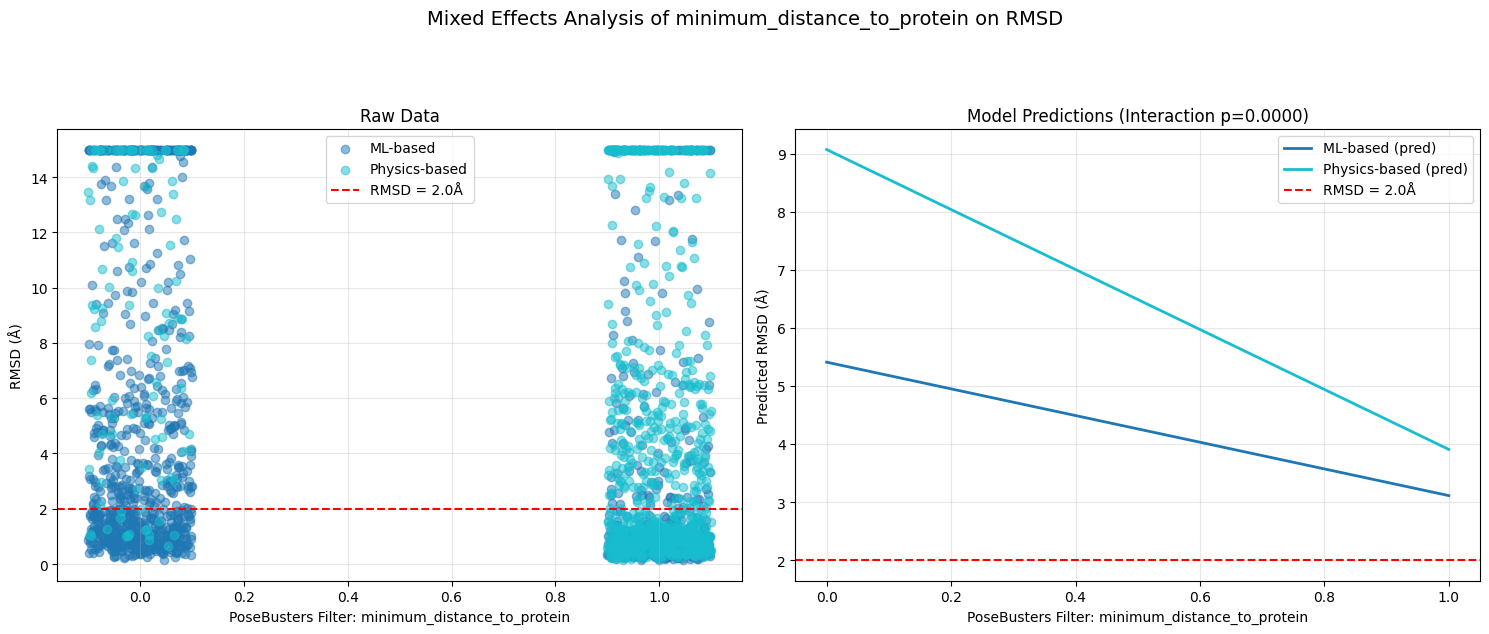

Property: minimum_distance_to_organic_cofactors
                                          Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       outcome   
No. Observations:                       2335                          Method:                                   REML      
No. Groups:                             562                           Scale:                                    23.5887   
Min. group size:                        1                             Log-Likelihood:                           -7126.4406
Max. group size:                        5                             Converged:                                Yes       
Mean group size:                        4.2                                                                               
--------------------------------------------------------------------------------------------------------------------------
           

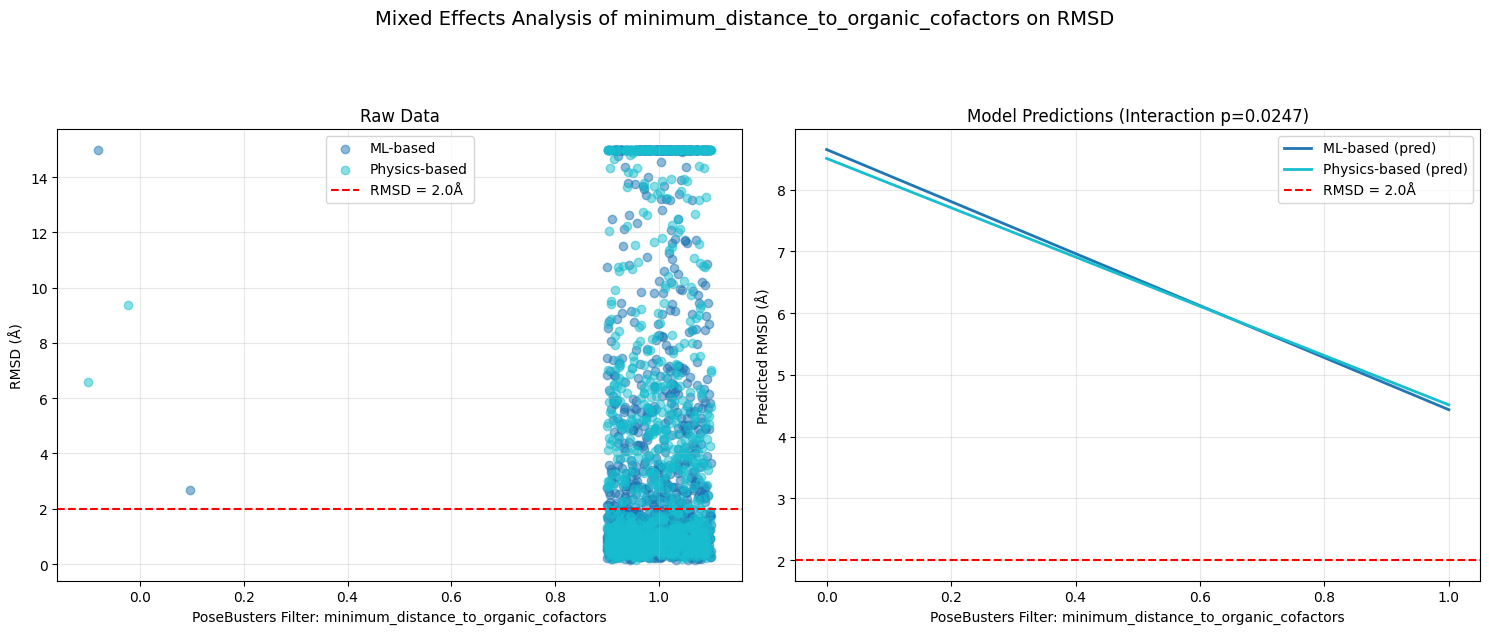

Property: minimum_distance_to_inorganic_cofactors
Error fitting mixed effects model: Singular matrix
Property: volume_overlap_with_protein
                                     Mixed Linear Model Regression Results
Model:                                MixedLM                   Dependent Variable:                   outcome   
No. Observations:                     2335                      Method:                               REML      
No. Groups:                           562                       Scale:                                19.6255   
Min. group size:                      1                         Log-Likelihood:                       -6938.3379
Max. group size:                      5                         Converged:                            Yes       
Mean group size:                      4.2                                                                       
------------------------------------------------------------------------------------------------------------

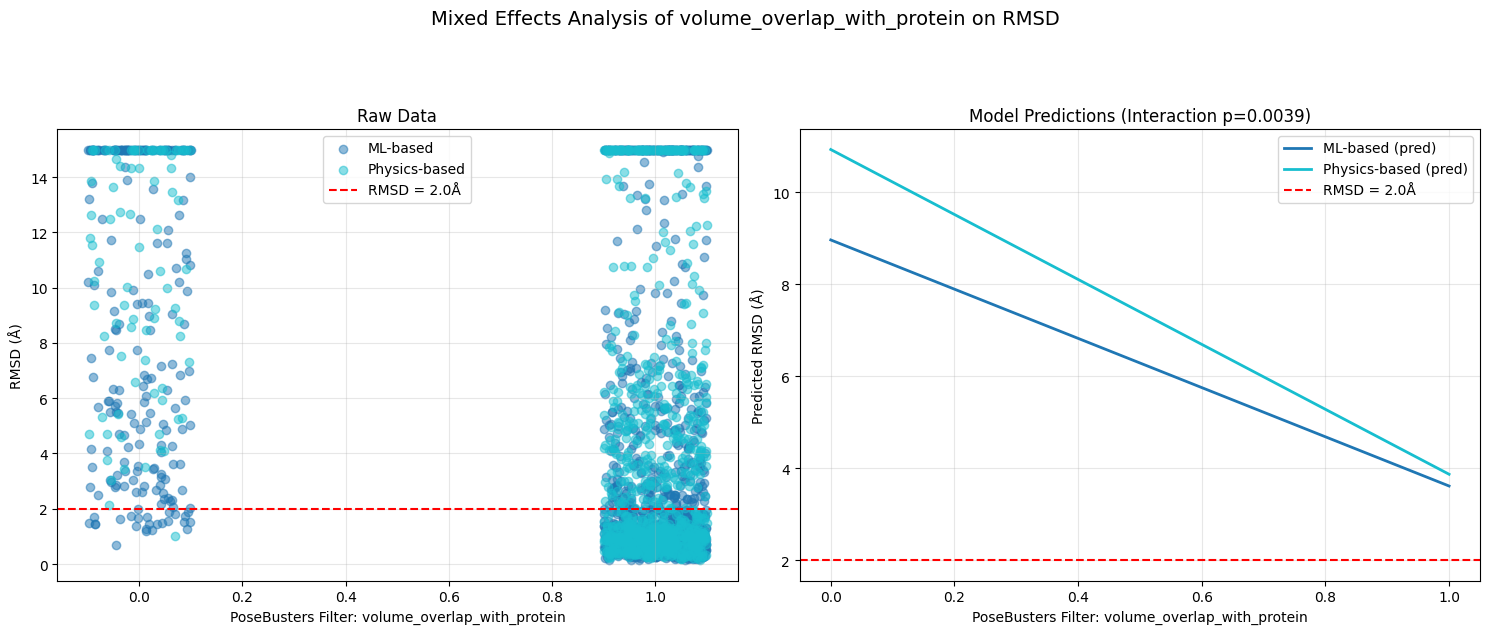

Property: volume_overlap_with_organic_cofactors
                                          Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       outcome   
No. Observations:                       2335                          Method:                                   REML      
No. Groups:                             562                           Scale:                                    23.5986   
Min. group size:                        1                             Log-Likelihood:                           -7126.3754
Max. group size:                        5                             Converged:                                Yes       
Mean group size:                        4.2                                                                               
--------------------------------------------------------------------------------------------------------------------------
           

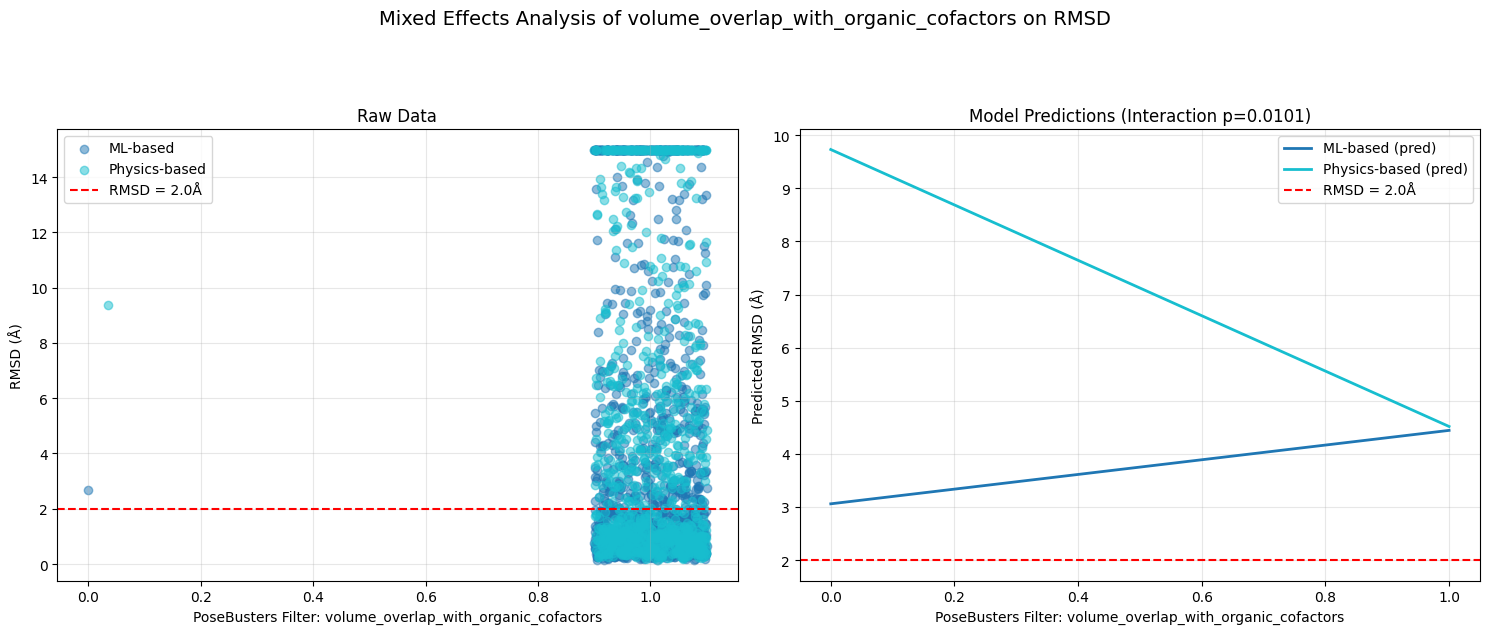

Property: volume_overlap_with_inorganic_cofactors
                                           Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       outcome   
No. Observations:                         2335                          Method:                                   REML      
No. Groups:                               562                           Scale:                                    23.5986   
Min. group size:                          1                             Log-Likelihood:                           -7126.3754
Max. group size:                          5                             Converged:                                Yes       
Mean group size:                          4.2                                                                               
-----------------------------------------------------------------------------------------------------------------------

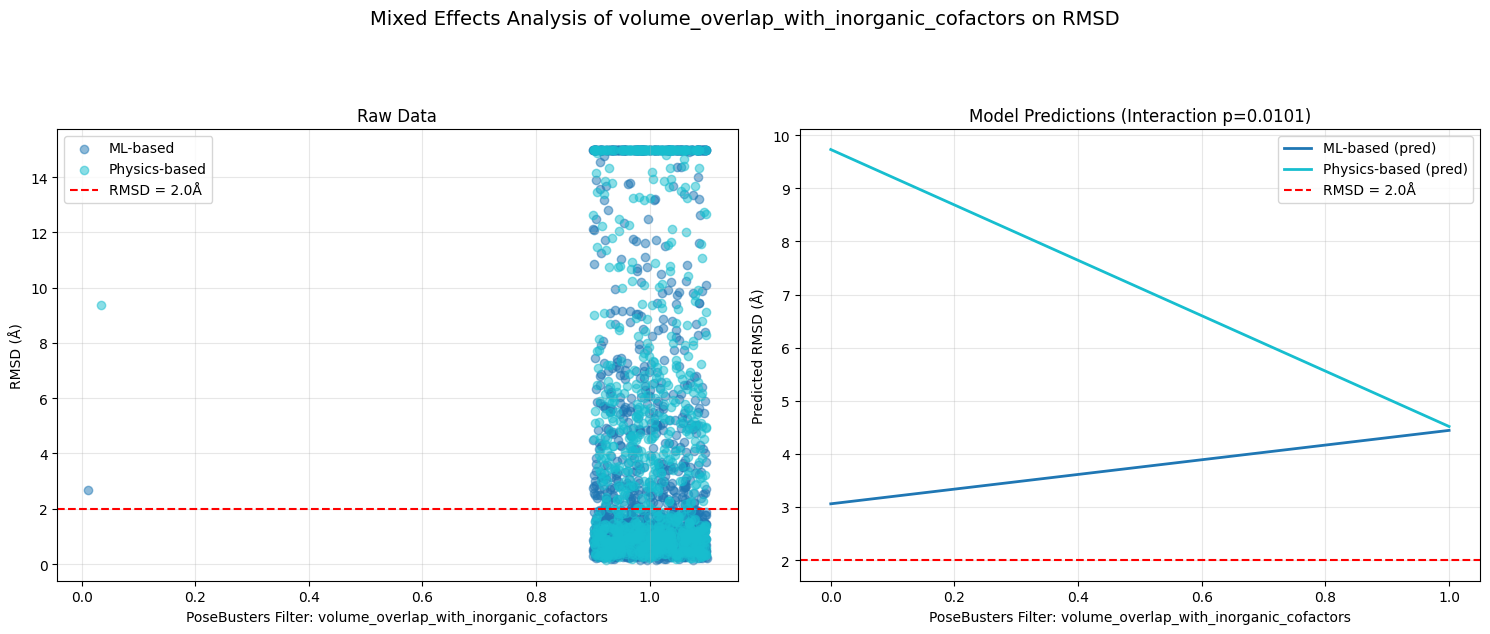

In [13]:
for prop in BUST_TEST_COLUMNS[1:]:
    print("Property:", prop)
    result = analysis.mixed_effect_analysis(
        filter_name=prop,
        method_groups={
            'ML-based': ['diffdock_pocket_only', 'chai-1', 'surfdock'], 
            'Physics-based': ['vina', 'icm']
        },
        rmsd_threshold=2.0,
        outcome_type='rmsd',
        plot=True
    )